In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Concatenate, Dropout, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




import os
import glob

In [5]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [6]:
# network parameters
width = 64
height = 64
latent_dim = 200

n_conds = 40
h = 0
w = 0
c = 0



# VAE model = encoder + decoder
def build_encoder():
    global h
    global w
    global c
    # build encoder model
    inputs = Input(shape=(width,height,3), name='encoder_input')
    condition_inputs = Input(shape=(n_conds,), name='encoder_cond_input')


    # x = GaussianNoise(1)(inputs) #Noise layer for denoising VAE
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    (_,h,w,c) = x.shape

    x = Flatten()(x)
    x = Concatenate()([x, condition_inputs])


    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    return Model([inputs,condition_inputs], [z_mean, z_log_var, z], name='encoder')
encoder = build_encoder()
encoder.summary()


def build_decoder():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    decoder_condition = Input(shape=(n_conds,), name='decoder_condition')



    x = Concatenate()([latent_inputs,decoder_condition])
    x = Dense(h*w*c)(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((h,w,c))(x)


    x = UpSampling2D()(x)
    x = Conv2D(256,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = UpSampling2D()(x)
    x = Conv2D(128,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # 



    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = UpSampling2D()(x)



    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)






    outputs_hi = Conv2D(3,5, strides=1, activation='tanh', padding='same')(x)


    # # instantiate decoder model
    return Model([latent_inputs,decoder_condition], outputs_hi, name='decoder')
decoder = build_decoder()
decoder.summary()








Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [7]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [8]:
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [9]:
# Fine feature model
dfc_layers = ["block1_conv1","block2_conv1","block3_conv1"]
#dfc_layer_weights = [1.0/3.0, 1.0/3.0, 1.0/3.0]

dfc_outputs = [vgg19.get_layer(l).output for l in dfc_layers]
dfc_loss_model = Model(vgg19.input, dfc_outputs, name="dfc_model")
dfc_loss_model.summary()

Model: "dfc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0 

In [12]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [13]:
df = pd.read_csv('./celeba-attribs.csv')

In [14]:
training_data_generator = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=False,
    preprocessing_function=normalize_for_tanh)


training_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(64, 64),
    subset='training',
    shuffle=True,
    batch_size=162080,
    class_mode='raw')

Found 162080 validated image filenames.


In [15]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present > 0:
            print(attrib, present)

In [432]:
def attribs_to_str(encoded):

    return "\n".join([" : ".join([ attrib,str(present)]) for (present, attrib) in zip(encoded, get_attribs()) if present > 0 or present < -1])
#         if present > 0:
#             print(attrib, present)

In [326]:
["".join((x,y)) for (x,y) in zip(range(10), range(10))]

TypeError: sequence item 0: expected str instance, int found

In [437]:
conditions = np.array([slider.value for slider in sliders])
print(attribs_to_str(conditions))

Goatee : 10.0


In [16]:
training_data = training_generator.next()

In [18]:
bce = tf.keras.losses.BinaryCrossentropy()
bce_smooth = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

@tf.function
def prep_for_vgg19(imgs):
    return ((imgs + 1) / 2)

@tf.function
def tanh_cross_entropy(y_true, y_pred):
    return -K.mean( (y_true+1)/2 * K.log( (y_pred+1)/2 + K.epsilon()) + (1 - (y_true+1)/2) * K.log(1 - (y_pred+1)/2 + K.epsilon()))
    

@tf.function
def kullback_leibler_divergence_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(kl_loss)

@tf.function
def discriminator_loss(real_output, decoded_output, fake_output):
    real_loss = bce(K.random_uniform(K.int_shape(real_output), minval=0.9, maxval=1.0), real_output)
    decoded_loss = bce(K.random_uniform(K.int_shape(decoded_output), minval=0.0, maxval=0.1), decoded_output)
    fake_loss = bce(K.random_uniform(K.int_shape(fake_output), minval=0.0, maxval=0.1), fake_output)
    total_loss = real_loss + fake_loss + decoded_loss
    return K.mean(total_loss)

@tf.function
def generator_loss(decoded_output, fake_output):
    decoded_loss = bce(K.ones_like(decoded_output), decoded_output)
    fake_loss = bce(K.ones_like(fake_output), fake_output)
    total_loss = fake_loss + decoded_loss
    return K.mean(total_loss)

@tf.function
def attribute_loss(true_attributes, predicted_attributes):
    total_loss = tanh_cross_entropy(true_attributes, predicted_attributes)    
    return K.mean(total_loss)

@tf.function
def discriminator_attrib_loss(true_attribs, real_attribs, decoded_attribs, fake_attribs):
    smoothing = K.random_uniform(K.int_shape(true_attribs), minval=0.9, maxval=1.0)
    real_loss = tanh_cross_entropy(true_attribs * smoothing, real_attribs)
    decoded_loss = tanh_cross_entropy(-true_attribs * smoothing, decoded_attribs)
    fake_loss = tanh_cross_entropy(-true_attribs * smoothing, fake_attribs)
    total_loss = real_loss + fake_loss + decoded_loss
    return K.mean(total_loss)

@tf.function
def generator_attrib_loss(true_attribs, decoded_attribs, fake_attribs):
    decoded_loss = tanh_cross_entropy(true_attribs, decoded_attribs)
    fake_loss = tanh_cross_entropy(true_attribs, fake_attribs)
    total_loss = fake_loss + decoded_loss
    return K.mean(total_loss)


@tf.function
def reconstruction_loss(y_true, y_pred):
    return tanh_cross_entropy(y_true, y_pred)


@tf.function
def perceptual_loss(real_image, predicted_image, dfc_loss_model):

    h1_hi, h1_med, h1_lo = dfc_loss_model(real_image)
    h2_hi, h2_med, h2_lo = dfc_loss_model(predicted_image)
    

    

    h1_hi = K.batch_flatten(h1_hi)
    h2_hi = K.batch_flatten(h2_hi)        
    rc_loss_hi = mse(h1_hi, h2_hi)
    
    h1_med = K.batch_flatten(h1_med)
    h2_med = K.batch_flatten(h2_med)        
    rc_loss_med = mse(h1_med, h2_med)
    
    h1_lo = K.batch_flatten(h1_lo)
    h2_lo = K.batch_flatten(h2_lo)        
    rc_loss_lo = mse(h1_lo, h2_lo)
    

    
    return K.mean(rc_loss_hi), K.mean(rc_loss_med), K.mean(rc_loss_lo)       



In [136]:
encoder = build_encoder()
decoder = build_decoder()
decoder_optimizer = tf.keras.optimizers.Adam(2e-4)
encoder_optimizer = tf.keras.optimizers.Adam(2e-4)

In [137]:
@tf.function
def train_step(images, attributes, beta):
    
    rl_scalar = 1.0
    
    with tf.GradientTape() as dec_tape, tf.GradientTape() as enc_tape:

     
        dec_tape.watch(decoder.trainable_variables)
        enc_tape.watch(encoder.trainable_variables)

        
        z_mean, z_log_var, z = encoder([images,attributes], training=True)        
        decoded_images_combo = decoder([z, attributes], training=True)
        
        kl_loss = kullback_leibler_divergence_loss(z_mean, z_log_var)
        


        
        
        rl_hi, rl_med, rl_lo = perceptual_loss(decoded_images_combo,  images, dfc_loss_model)
        
        # for balance
        rl_hi = 12.0 * rl_hi
        rl_med = 0.25 * rl_med
        rl_lo = 0.1 * rl_lo
        
        # for the mean
        rl_loss = (rl_lo +  rl_med + rl_hi) / 3 
        
          

        
        decoder_loss = rl_loss * rl_scalar 

        encoder_loss = kl_loss * beta + rl_loss * rl_scalar
        





    gradients_of_encoder = enc_tape.gradient(encoder_loss, encoder.trainable_variables)
    gradients_of_decoder = dec_tape.gradient(decoder_loss, decoder.trainable_variables)
    
    
    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
    decoder_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))


    

    

    return rl_lo, rl_med, rl_hi, kl_loss



Epoch [1/500]...    ...189.382(s) feat_lo: 1.50494 - feat_med: 1.52555 - feat_hi: 1.50901 - KL: 49.99079
Epoch [2/500]...    ...184.086(s) feat_lo: 1.22863 - feat_med: 1.28037 - feat_hi: 1.23553 - KL: 50.01161
Epoch [3/500]...    ...183.632(s) feat_lo: 1.15975 - feat_med: 1.21502 - feat_hi: 1.17750 - KL: 49.99609
Epoch [4/500]...    ...183.737(s) feat_lo: 1.12444 - feat_med: 1.18123 - feat_hi: 1.14718 - KL: 50.00072
Epoch [5/500]...    ...184.080(s) feat_lo: 1.10296 - feat_med: 1.16017 - feat_hi: 1.12574 - KL: 50.00643
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


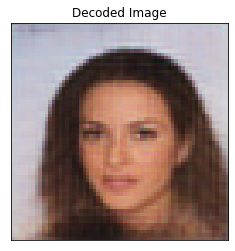

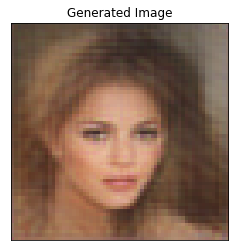

Epoch [6/500]...    ...183.950(s) feat_lo: 1.08678 - feat_med: 1.14466 - feat_hi: 1.11038 - KL: 49.99174
Epoch [7/500]...    ...183.961(s) feat_lo: 1.07417 - feat_med: 1.13280 - feat_hi: 1.09920 - KL: 50.00350
Epoch [8/500]...    ...183.973(s) feat_lo: 1.06424 - feat_med: 1.12357 - feat_hi: 1.09114 - KL: 49.99688
Epoch [9/500]...    ...184.004(s) feat_lo: 1.05655 - feat_med: 1.11643 - feat_hi: 1.08495 - KL: 49.99656
Epoch [10/500]...   ...184.038(s) feat_lo: 1.04939 - feat_med: 1.10967 - feat_hi: 1.07904 - KL: 50.01023
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


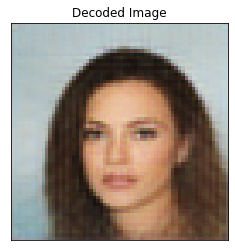

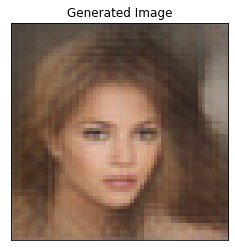

Epoch [11/500]...   ...184.118(s) feat_lo: 1.04363 - feat_med: 1.10426 - feat_hi: 1.07433 - KL: 49.99890
Epoch [12/500]...   ...184.053(s) feat_lo: 1.03885 - feat_med: 1.09974 - feat_hi: 1.07027 - KL: 49.99522
Epoch [13/500]...   ...184.047(s) feat_lo: 1.03475 - feat_med: 1.09578 - feat_hi: 1.06701 - KL: 50.00470
Epoch [14/500]...   ...184.078(s) feat_lo: 1.03043 - feat_med: 1.09191 - feat_hi: 1.06331 - KL: 49.99661
Epoch [15/500]...   ...184.053(s) feat_lo: 1.02686 - feat_med: 1.08845 - feat_hi: 1.06029 - KL: 50.00143
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


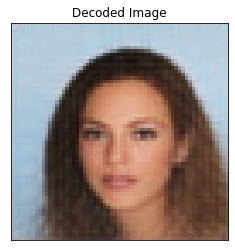

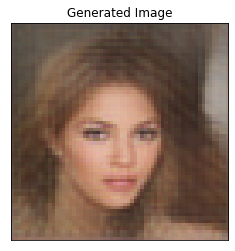

Epoch [16/500]...   ...184.047(s) feat_lo: 1.02400 - feat_med: 1.08578 - feat_hi: 1.05832 - KL: 50.00054
Epoch [17/500]...   ...184.050(s) feat_lo: 1.02125 - feat_med: 1.08316 - feat_hi: 1.05591 - KL: 49.99846
Epoch [18/500]...   ...183.990(s) feat_lo: 1.01838 - feat_med: 1.08034 - feat_hi: 1.05344 - KL: 50.00107
Epoch [19/500]...   ...184.050(s) feat_lo: 1.01579 - feat_med: 1.07787 - feat_hi: 1.05137 - KL: 49.99858
Epoch [20/500]...   ...183.983(s) feat_lo: 1.01345 - feat_med: 1.07565 - feat_hi: 1.04924 - KL: 50.00046
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


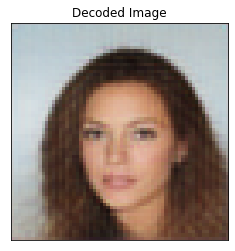

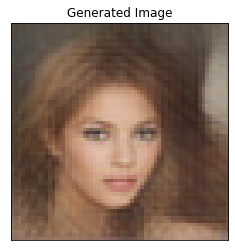

Epoch [21/500]...   ...184.072(s) feat_lo: 1.01141 - feat_med: 1.07369 - feat_hi: 1.04793 - KL: 49.99889
Epoch [22/500]...   ...184.068(s) feat_lo: 1.00929 - feat_med: 1.07165 - feat_hi: 1.04595 - KL: 50.00379
Epoch [23/500]...   ...184.044(s) feat_lo: 1.00740 - feat_med: 1.06987 - feat_hi: 1.04446 - KL: 50.00064
Epoch [24/500]...   ...184.051(s) feat_lo: 1.00592 - feat_med: 1.06846 - feat_hi: 1.04329 - KL: 49.99462
Epoch [25/500]...   ...184.068(s) feat_lo: 1.00433 - feat_med: 1.06695 - feat_hi: 1.04209 - KL: 50.00115
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


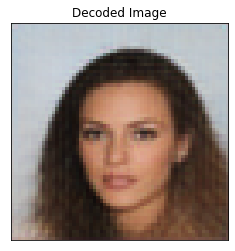

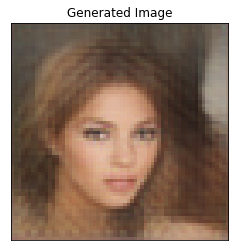

Epoch [26/500]...   ...184.064(s) feat_lo: 1.00271 - feat_med: 1.06524 - feat_hi: 1.04052 - KL: 50.00091
Epoch [27/500]...   ...184.076(s) feat_lo: 1.00123 - feat_med: 1.06382 - feat_hi: 1.03925 - KL: 50.00727
Epoch [28/500]...   ...184.666(s) feat_lo: 0.99967 - feat_med: 1.06234 - feat_hi: 1.03795 - KL: 49.99353
Epoch [29/500]...   ...184.445(s) feat_lo: 0.99829 - feat_med: 1.06102 - feat_hi: 1.03683 - KL: 49.99667
Epoch [30/500]...   ...184.269(s) feat_lo: 0.99682 - feat_med: 1.05950 - feat_hi: 1.03550 - KL: 50.00289
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


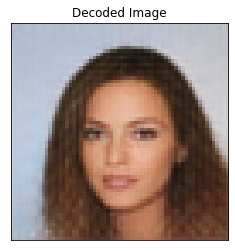

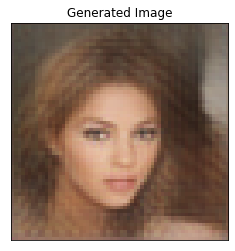

Epoch [31/500]...   ...184.312(s) feat_lo: 0.99578 - feat_med: 1.05855 - feat_hi: 1.03474 - KL: 50.00383
Epoch [32/500]...   ...184.302(s) feat_lo: 0.99467 - feat_med: 1.05752 - feat_hi: 1.03383 - KL: 49.99619
Epoch [33/500]...   ...184.315(s) feat_lo: 0.99326 - feat_med: 1.05621 - feat_hi: 1.03263 - KL: 50.00278
Epoch [34/500]...   ...184.166(s) feat_lo: 0.99242 - feat_med: 1.05529 - feat_hi: 1.03184 - KL: 50.00067
Epoch [35/500]...   ...184.047(s) feat_lo: 0.99148 - feat_med: 1.05437 - feat_hi: 1.03117 - KL: 49.99452
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


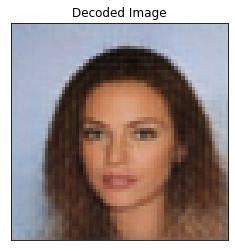

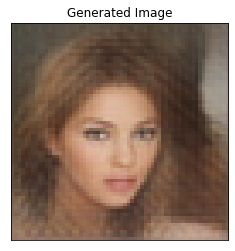

Epoch [36/500]...   ...184.066(s) feat_lo: 0.99039 - feat_med: 1.05333 - feat_hi: 1.03000 - KL: 50.00385
Epoch [37/500]...   ...184.057(s) feat_lo: 0.98927 - feat_med: 1.05232 - feat_hi: 1.02919 - KL: 49.99990
Epoch [38/500]...   ...184.059(s) feat_lo: 0.98865 - feat_med: 1.05151 - feat_hi: 1.02850 - KL: 49.99913
Epoch [39/500]...   ...184.048(s) feat_lo: 0.98763 - feat_med: 1.05065 - feat_hi: 1.02783 - KL: 50.00125
Epoch [40/500]...   ...184.023(s) feat_lo: 0.98699 - feat_med: 1.05000 - feat_hi: 1.02723 - KL: 49.99928
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


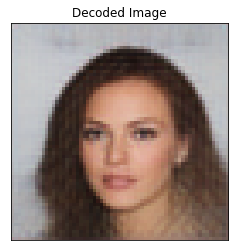

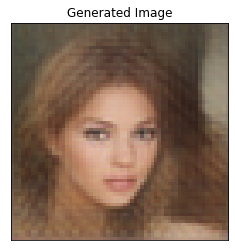

Epoch [41/500]...   ...184.062(s) feat_lo: 0.98601 - feat_med: 1.04901 - feat_hi: 1.02620 - KL: 49.99844
Epoch [42/500]...   ...184.066(s) feat_lo: 0.98544 - feat_med: 1.04838 - feat_hi: 1.02566 - KL: 50.00065
Epoch [43/500]...   ...184.055(s) feat_lo: 0.98445 - feat_med: 1.04744 - feat_hi: 1.02476 - KL: 50.00050
Epoch [44/500]...   ...184.062(s) feat_lo: 0.98368 - feat_med: 1.04681 - feat_hi: 1.02436 - KL: 49.99952
Epoch [45/500]...   ...184.085(s) feat_lo: 0.98321 - feat_med: 1.04633 - feat_hi: 1.02386 - KL: 49.99966
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


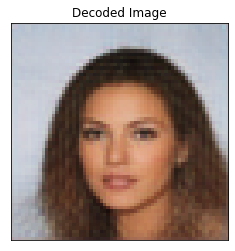

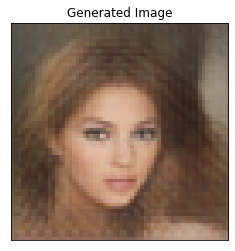

Epoch [46/500]...   ...184.001(s) feat_lo: 0.98246 - feat_med: 1.04545 - feat_hi: 1.02303 - KL: 49.99852
Epoch [47/500]...   ...184.024(s) feat_lo: 0.98175 - feat_med: 1.04487 - feat_hi: 1.02261 - KL: 50.00363
Epoch [48/500]...   ...184.007(s) feat_lo: 0.98098 - feat_med: 1.04410 - feat_hi: 1.02177 - KL: 49.99996
Epoch [49/500]...   ...183.780(s) feat_lo: 0.98044 - feat_med: 1.04345 - feat_hi: 1.02117 - KL: 49.99942
Epoch [50/500]...   ...183.747(s) feat_lo: 0.97971 - feat_med: 1.04288 - feat_hi: 1.02075 - KL: 50.00037
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


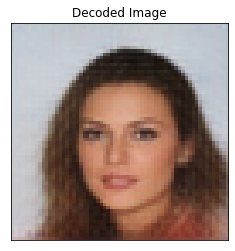

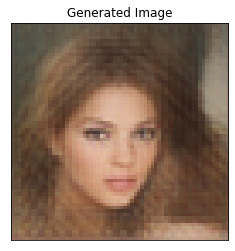

checkpointing at epoch: 50
Epoch [51/500]...   ...183.876(s) feat_lo: 0.97921 - feat_med: 1.04249 - feat_hi: 1.02054 - KL: 49.99975
Epoch [52/500]...   ...183.845(s) feat_lo: 0.97844 - feat_med: 1.04170 - feat_hi: 1.01954 - KL: 50.00583
Epoch [53/500]...   ...183.889(s) feat_lo: 0.97806 - feat_med: 1.04127 - feat_hi: 1.01917 - KL: 49.99434
Epoch [54/500]...   ...183.847(s) feat_lo: 0.97745 - feat_med: 1.04059 - feat_hi: 1.01859 - KL: 50.00319
Epoch [55/500]...   ...183.884(s) feat_lo: 0.97682 - feat_med: 1.03995 - feat_hi: 1.01805 - KL: 49.99506
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


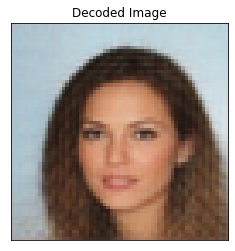

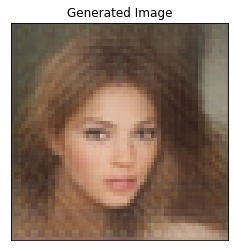

Epoch [56/500]...   ...183.848(s) feat_lo: 0.97656 - feat_med: 1.03975 - feat_hi: 1.01797 - KL: 50.00101
Epoch [57/500]...   ...183.942(s) feat_lo: 0.97593 - feat_med: 1.03917 - feat_hi: 1.01739 - KL: 49.99917
Epoch [58/500]...   ...183.998(s) feat_lo: 0.97569 - feat_med: 1.03892 - feat_hi: 1.01724 - KL: 50.00128
Epoch [59/500]...   ...183.858(s) feat_lo: 0.97515 - feat_med: 1.03838 - feat_hi: 1.01677 - KL: 50.00123
Epoch [60/500]...   ...183.924(s) feat_lo: 0.97465 - feat_med: 1.03793 - feat_hi: 1.01622 - KL: 49.99831
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


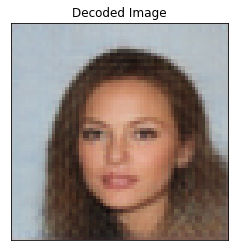

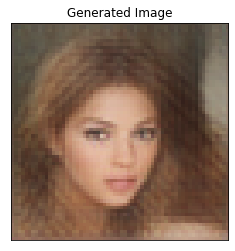

Epoch [61/500]...   ...183.989(s) feat_lo: 0.97403 - feat_med: 1.03728 - feat_hi: 1.01565 - KL: 50.00101
Epoch [62/500]...   ...184.008(s) feat_lo: 0.97347 - feat_med: 1.03676 - feat_hi: 1.01498 - KL: 50.00133
Epoch [63/500]...   ...183.969(s) feat_lo: 0.97305 - feat_med: 1.03639 - feat_hi: 1.01492 - KL: 49.99910
Epoch [64/500]...   ...183.932(s) feat_lo: 0.97263 - feat_med: 1.03590 - feat_hi: 1.01449 - KL: 49.99664
Epoch [65/500]...   ...183.994(s) feat_lo: 0.97217 - feat_med: 1.03550 - feat_hi: 1.01405 - KL: 50.00302
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


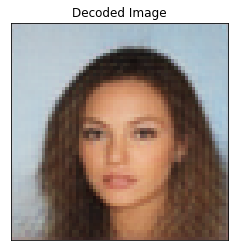

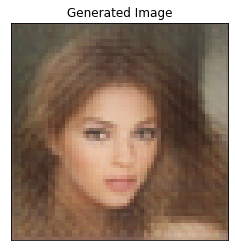

Epoch [66/500]...   ...183.832(s) feat_lo: 0.97181 - feat_med: 1.03507 - feat_hi: 1.01352 - KL: 49.99935
Epoch [67/500]...   ...183.900(s) feat_lo: 0.97119 - feat_med: 1.03453 - feat_hi: 1.01326 - KL: 50.00164
Epoch [68/500]...   ...183.939(s) feat_lo: 0.97094 - feat_med: 1.03417 - feat_hi: 1.01279 - KL: 49.99828
Epoch [69/500]...   ...183.812(s) feat_lo: 0.97067 - feat_med: 1.03401 - feat_hi: 1.01268 - KL: 49.99782
Epoch [70/500]...   ...183.865(s) feat_lo: 0.97046 - feat_med: 1.03381 - feat_hi: 1.01249 - KL: 50.00031
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


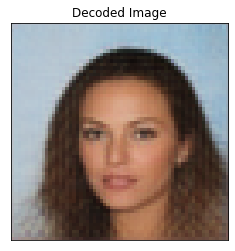

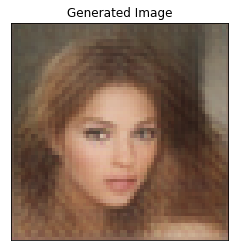

Epoch [71/500]...   ...183.803(s) feat_lo: 0.96975 - feat_med: 1.03320 - feat_hi: 1.01203 - KL: 50.00057
Epoch [72/500]...   ...183.895(s) feat_lo: 0.96941 - feat_med: 1.03277 - feat_hi: 1.01157 - KL: 50.00419
Epoch [73/500]...   ...183.904(s) feat_lo: 0.96920 - feat_med: 1.03260 - feat_hi: 1.01133 - KL: 49.99566
Epoch [74/500]...   ...183.920(s) feat_lo: 0.96871 - feat_med: 1.03214 - feat_hi: 1.01102 - KL: 49.99837
Epoch [75/500]...   ...183.971(s) feat_lo: 0.96830 - feat_med: 1.03176 - feat_hi: 1.01058 - KL: 50.00179
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


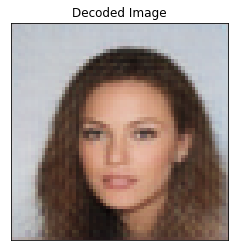

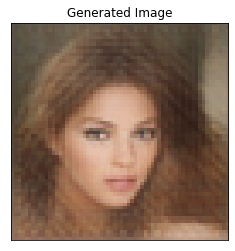

Epoch [76/500]...   ...183.852(s) feat_lo: 0.96806 - feat_med: 1.03144 - feat_hi: 1.01031 - KL: 50.00257
Epoch [77/500]...   ...183.713(s) feat_lo: 0.96785 - feat_med: 1.03138 - feat_hi: 1.01030 - KL: 49.99936
Epoch [78/500]...   ...183.801(s) feat_lo: 0.96757 - feat_med: 1.03097 - feat_hi: 1.00985 - KL: 49.99974
Epoch [79/500]...   ...183.791(s) feat_lo: 0.96696 - feat_med: 1.03044 - feat_hi: 1.00958 - KL: 49.99963
Epoch [80/500]...   ...183.790(s) feat_lo: 0.96680 - feat_med: 1.03025 - feat_hi: 1.00925 - KL: 50.00318
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


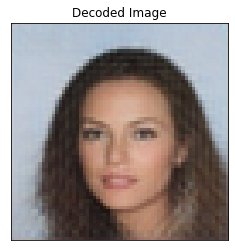

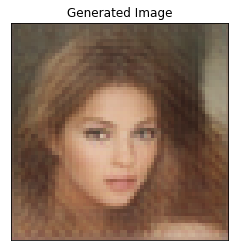

Epoch [81/500]...   ...183.822(s) feat_lo: 0.96651 - feat_med: 1.02993 - feat_hi: 1.00912 - KL: 49.99648
Epoch [82/500]...   ...183.918(s) feat_lo: 0.96627 - feat_med: 1.02975 - feat_hi: 1.00883 - KL: 49.99347
Epoch [83/500]...   ...184.108(s) feat_lo: 0.96589 - feat_med: 1.02930 - feat_hi: 1.00843 - KL: 50.01000
Epoch [84/500]...   ...184.103(s) feat_lo: 0.96556 - feat_med: 1.02907 - feat_hi: 1.00822 - KL: 49.99631
Epoch [85/500]...   ...184.092(s) feat_lo: 0.96564 - feat_med: 1.02901 - feat_hi: 1.00798 - KL: 50.00180
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


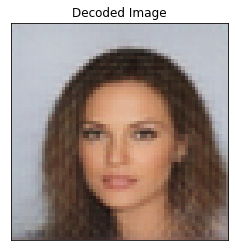

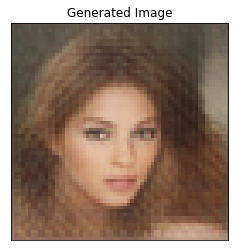

Epoch [86/500]...   ...184.018(s) feat_lo: 0.96480 - feat_med: 1.02831 - feat_hi: 1.00737 - KL: 49.99826
Epoch [87/500]...   ...184.025(s) feat_lo: 0.96457 - feat_med: 1.02805 - feat_hi: 1.00716 - KL: 50.00257
Epoch [88/500]...   ...184.118(s) feat_lo: 0.96409 - feat_med: 1.02766 - feat_hi: 1.00689 - KL: 49.99545
Epoch [89/500]...   ...184.123(s) feat_lo: 0.96404 - feat_med: 1.02749 - feat_hi: 1.00663 - KL: 50.00172
Epoch [90/500]...   ...184.050(s) feat_lo: 0.96403 - feat_med: 1.02740 - feat_hi: 1.00672 - KL: 50.00356
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


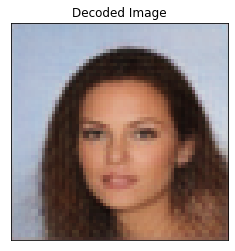

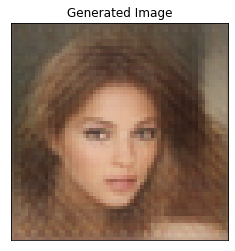

Epoch [91/500]...   ...183.972(s) feat_lo: 0.96374 - feat_med: 1.02717 - feat_hi: 1.00620 - KL: 49.99830
Epoch [92/500]...   ...183.916(s) feat_lo: 0.96346 - feat_med: 1.02689 - feat_hi: 1.00615 - KL: 49.99898
Epoch [93/500]...   ...183.989(s) feat_lo: 0.96319 - feat_med: 1.02672 - feat_hi: 1.00596 - KL: 50.00086
Epoch [94/500]...   ...184.013(s) feat_lo: 0.96295 - feat_med: 1.02639 - feat_hi: 1.00568 - KL: 49.99986
Epoch [95/500]...   ...184.012(s) feat_lo: 0.96253 - feat_med: 1.02607 - feat_hi: 1.00548 - KL: 50.00146
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


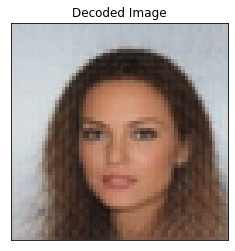

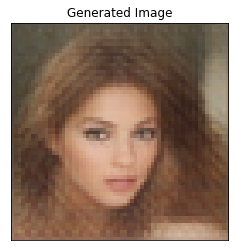

Epoch [96/500]...   ...183.993(s) feat_lo: 0.96241 - feat_med: 1.02597 - feat_hi: 1.00529 - KL: 49.99639
Epoch [97/500]...   ...183.933(s) feat_lo: 0.96193 - feat_med: 1.02538 - feat_hi: 1.00473 - KL: 49.99859
Epoch [98/500]...   ...183.959(s) feat_lo: 0.96186 - feat_med: 1.02532 - feat_hi: 1.00464 - KL: 50.00064
Epoch [99/500]...   ...184.043(s) feat_lo: 0.96180 - feat_med: 1.02521 - feat_hi: 1.00467 - KL: 50.00316
Epoch [100/500]...  ...184.044(s) feat_lo: 0.96151 - feat_med: 1.02497 - feat_hi: 1.00436 - KL: 49.99899
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


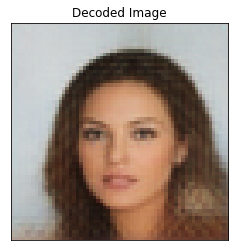

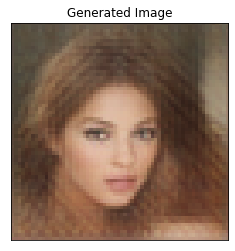

checkpointing at epoch: 100
Epoch [101/500]...  ...183.989(s) feat_lo: 0.96115 - feat_med: 1.02461 - feat_hi: 1.00411 - KL: 50.00087
Epoch [102/500]...  ...184.085(s) feat_lo: 0.96103 - feat_med: 1.02456 - feat_hi: 1.00406 - KL: 49.99781
Epoch [103/500]...  ...184.052(s) feat_lo: 0.96097 - feat_med: 1.02443 - feat_hi: 1.00390 - KL: 50.00047
Epoch [104/500]...  ...184.013(s) feat_lo: 0.96059 - feat_med: 1.02394 - feat_hi: 1.00339 - KL: 50.00275
Epoch [105/500]...  ...184.047(s) feat_lo: 0.96031 - feat_med: 1.02389 - feat_hi: 1.00338 - KL: 50.00065
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


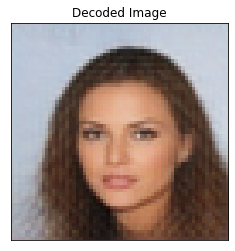

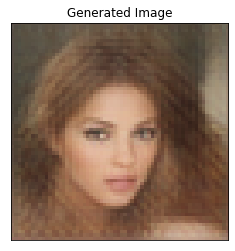

Epoch [106/500]...  ...184.106(s) feat_lo: 0.96024 - feat_med: 1.02371 - feat_hi: 1.00323 - KL: 49.99914
Epoch [107/500]...  ...184.008(s) feat_lo: 0.95992 - feat_med: 1.02350 - feat_hi: 1.00305 - KL: 49.99449
Epoch [108/500]...  ...183.928(s) feat_lo: 0.95963 - feat_med: 1.02312 - feat_hi: 1.00282 - KL: 50.00403
Epoch [109/500]...  ...183.951(s) feat_lo: 0.95938 - feat_med: 1.02303 - feat_hi: 1.00267 - KL: 49.99628
Epoch [110/500]...  ...183.872(s) feat_lo: 0.95930 - feat_med: 1.02285 - feat_hi: 1.00240 - KL: 50.00686
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


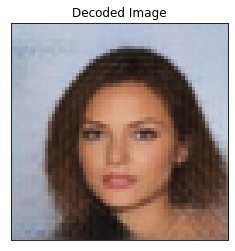

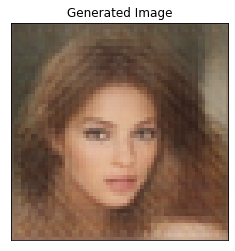

Epoch [111/500]...  ...183.825(s) feat_lo: 0.95870 - feat_med: 1.02233 - feat_hi: 1.00188 - KL: 49.99816
Epoch [112/500]...  ...183.792(s) feat_lo: 0.95870 - feat_med: 1.02219 - feat_hi: 1.00174 - KL: 49.99693
Epoch [113/500]...  ...183.850(s) feat_lo: 0.95841 - feat_med: 1.02183 - feat_hi: 1.00148 - KL: 50.00294
Epoch [114/500]...  ...183.763(s) feat_lo: 0.95870 - feat_med: 1.02224 - feat_hi: 1.00192 - KL: 49.99730
Epoch [115/500]...  ...183.798(s) feat_lo: 0.95806 - feat_med: 1.02147 - feat_hi: 1.00116 - KL: 50.00342
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


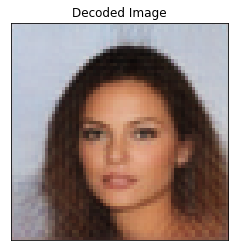

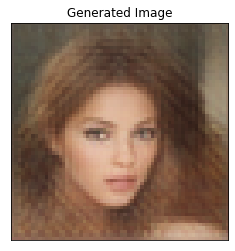

Epoch [116/500]...  ...183.855(s) feat_lo: 0.95817 - feat_med: 1.02173 - feat_hi: 1.00141 - KL: 49.99832
Epoch [117/500]...  ...183.825(s) feat_lo: 0.95775 - feat_med: 1.02123 - feat_hi: 1.00085 - KL: 49.99990
Epoch [118/500]...  ...183.817(s) feat_lo: 0.95748 - feat_med: 1.02111 - feat_hi: 1.00098 - KL: 50.00081
Epoch [119/500]...  ...183.743(s) feat_lo: 0.95743 - feat_med: 1.02097 - feat_hi: 1.00071 - KL: 49.99804
Epoch [120/500]...  ...183.508(s) feat_lo: 0.95707 - feat_med: 1.02066 - feat_hi: 1.00045 - KL: 50.00349
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


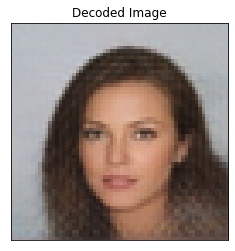

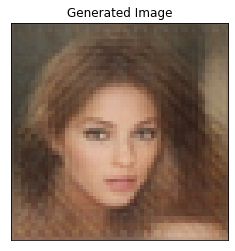

Epoch [121/500]...  ...183.699(s) feat_lo: 0.95709 - feat_med: 1.02066 - feat_hi: 1.00034 - KL: 49.99771
Epoch [122/500]...  ...183.682(s) feat_lo: 0.95704 - feat_med: 1.02052 - feat_hi: 1.00028 - KL: 50.00104
Epoch [123/500]...  ...183.644(s) feat_lo: 0.95661 - feat_med: 1.02019 - feat_hi: 0.99997 - KL: 49.99728
Epoch [124/500]...  ...183.639(s) feat_lo: 0.95689 - feat_med: 1.02047 - feat_hi: 1.00037 - KL: 50.00024
Epoch [125/500]...  ...183.837(s) feat_lo: 0.95646 - feat_med: 1.01993 - feat_hi: 0.99961 - KL: 50.00205
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


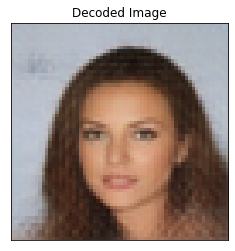

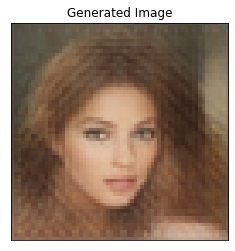

Epoch [126/500]...  ...183.539(s) feat_lo: 0.95633 - feat_med: 1.01987 - feat_hi: 0.99966 - KL: 49.99898
Epoch [127/500]...  ...183.538(s) feat_lo: 0.95601 - feat_med: 1.01958 - feat_hi: 0.99953 - KL: 49.99926
Epoch [128/500]...  ...183.818(s) feat_lo: 0.95591 - feat_med: 1.01935 - feat_hi: 0.99932 - KL: 49.99915
Epoch [129/500]...  ...183.691(s) feat_lo: 0.95564 - feat_med: 1.01927 - feat_hi: 0.99918 - KL: 50.00405
Epoch [130/500]...  ...183.748(s) feat_lo: 0.95553 - feat_med: 1.01910 - feat_hi: 0.99912 - KL: 49.99608
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


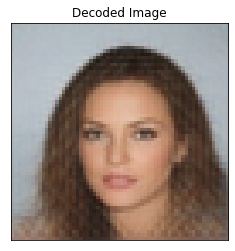

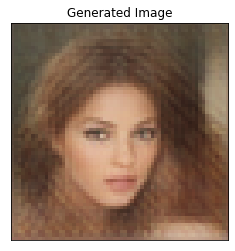

Epoch [131/500]...  ...183.834(s) feat_lo: 0.95537 - feat_med: 1.01889 - feat_hi: 0.99869 - KL: 50.00283
Epoch [132/500]...  ...183.843(s) feat_lo: 0.95555 - feat_med: 1.01907 - feat_hi: 0.99890 - KL: 49.99905
Epoch [133/500]...  ...183.727(s) feat_lo: 0.95515 - feat_med: 1.01874 - feat_hi: 0.99876 - KL: 49.99833
Epoch [134/500]...  ...183.856(s) feat_lo: 0.95498 - feat_med: 1.01848 - feat_hi: 0.99832 - KL: 50.00044
Epoch [135/500]...  ...183.858(s) feat_lo: 0.95488 - feat_med: 1.01847 - feat_hi: 0.99844 - KL: 50.00232
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


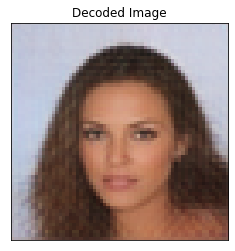

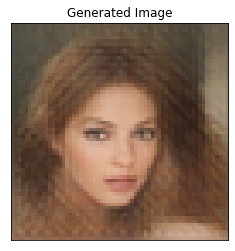

Epoch [136/500]...  ...183.882(s) feat_lo: 0.95479 - feat_med: 1.01839 - feat_hi: 0.99846 - KL: 50.00079
Epoch [137/500]...  ...183.851(s) feat_lo: 0.95449 - feat_med: 1.01808 - feat_hi: 0.99813 - KL: 49.99701
Epoch [138/500]...  ...183.849(s) feat_lo: 0.95440 - feat_med: 1.01788 - feat_hi: 0.99771 - KL: 50.00113
Epoch [139/500]...  ...183.889(s) feat_lo: 0.95428 - feat_med: 1.01781 - feat_hi: 0.99785 - KL: 49.99911
Epoch [140/500]...  ...183.966(s) feat_lo: 0.95414 - feat_med: 1.01765 - feat_hi: 0.99751 - KL: 50.00158
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


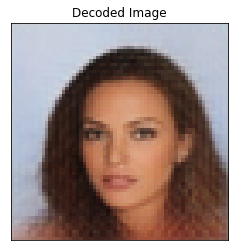

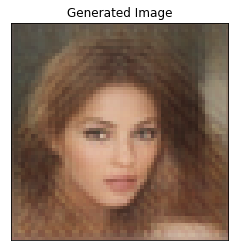

Epoch [141/500]...  ...184.024(s) feat_lo: 0.95397 - feat_med: 1.01758 - feat_hi: 0.99751 - KL: 49.99892
Epoch [142/500]...  ...184.016(s) feat_lo: 0.95376 - feat_med: 1.01727 - feat_hi: 0.99714 - KL: 50.00245
Epoch [143/500]...  ...184.172(s) feat_lo: 0.95341 - feat_med: 1.01708 - feat_hi: 0.99713 - KL: 50.00051
Epoch [144/500]...  ...184.553(s) feat_lo: 0.95367 - feat_med: 1.01720 - feat_hi: 0.99718 - KL: 49.99364
Epoch [145/500]...  ...184.297(s) feat_lo: 0.95333 - feat_med: 1.01696 - feat_hi: 0.99706 - KL: 50.00216
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


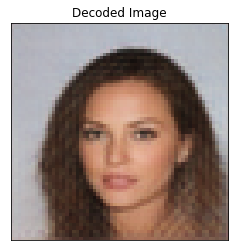

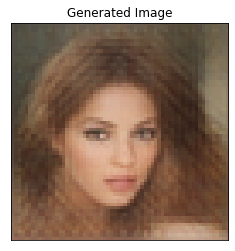

Epoch [146/500]...  ...184.200(s) feat_lo: 0.95327 - feat_med: 1.01680 - feat_hi: 0.99692 - KL: 49.99925
Epoch [147/500]...  ...184.137(s) feat_lo: 0.95305 - feat_med: 1.01659 - feat_hi: 0.99661 - KL: 49.99658
Epoch [148/500]...  ...184.111(s) feat_lo: 0.95298 - feat_med: 1.01651 - feat_hi: 0.99655 - KL: 50.00672
Epoch [149/500]...  ...183.918(s) feat_lo: 0.95283 - feat_med: 1.01636 - feat_hi: 0.99655 - KL: 50.00126
Epoch [150/500]...  ...183.788(s) feat_lo: 0.95293 - feat_med: 1.01641 - feat_hi: 0.99646 - KL: 49.99536
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


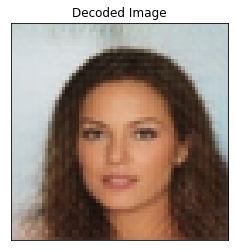

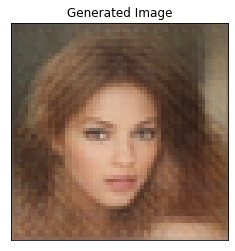

checkpointing at epoch: 150
Epoch [151/500]...  ...184.450(s) feat_lo: 0.95259 - feat_med: 1.01607 - feat_hi: 0.99612 - KL: 50.00035
Epoch [152/500]...  ...184.235(s) feat_lo: 0.95237 - feat_med: 1.01588 - feat_hi: 0.99604 - KL: 50.00148
Epoch [153/500]...  ...184.268(s) feat_lo: 0.95211 - feat_med: 1.01574 - feat_hi: 0.99589 - KL: 50.00079
Epoch [154/500]...  ...184.311(s) feat_lo: 0.95233 - feat_med: 1.01588 - feat_hi: 0.99601 - KL: 50.00027
Epoch [155/500]...  ...184.283(s) feat_lo: 0.95199 - feat_med: 1.01548 - feat_hi: 0.99576 - KL: 49.99679
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


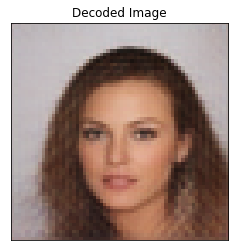

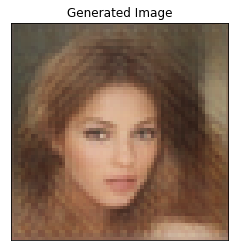

Epoch [156/500]...  ...184.146(s) feat_lo: 0.95207 - feat_med: 1.01553 - feat_hi: 0.99573 - KL: 50.00229
Epoch [157/500]...  ...183.958(s) feat_lo: 0.95170 - feat_med: 1.01529 - feat_hi: 0.99557 - KL: 50.00195
Epoch [158/500]...  ...183.990(s) feat_lo: 0.95175 - feat_med: 1.01525 - feat_hi: 0.99545 - KL: 49.99776
Epoch [159/500]...  ...183.927(s) feat_lo: 0.95154 - feat_med: 1.01514 - feat_hi: 0.99548 - KL: 50.00073
Epoch [160/500]...  ...183.808(s) feat_lo: 0.95150 - feat_med: 1.01507 - feat_hi: 0.99541 - KL: 49.99911
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


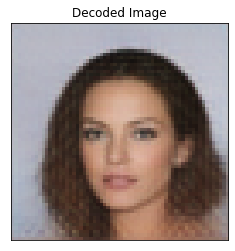

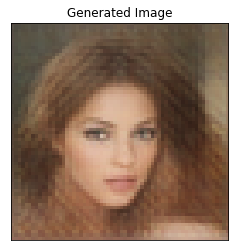

Epoch [161/500]...  ...183.819(s) feat_lo: 0.95123 - feat_med: 1.01474 - feat_hi: 0.99498 - KL: 50.00202
Epoch [162/500]...  ...183.854(s) feat_lo: 0.95102 - feat_med: 1.01464 - feat_hi: 0.99484 - KL: 49.99735
Epoch [163/500]...  ...183.874(s) feat_lo: 0.95109 - feat_med: 1.01468 - feat_hi: 0.99496 - KL: 49.99725
Epoch [164/500]...  ...183.791(s) feat_lo: 0.95091 - feat_med: 1.01449 - feat_hi: 0.99467 - KL: 50.00492
Epoch [165/500]...  ...183.830(s) feat_lo: 0.95077 - feat_med: 1.01418 - feat_hi: 0.99453 - KL: 49.99948
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


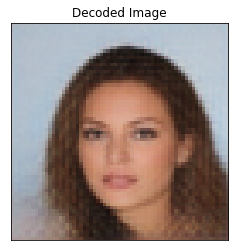

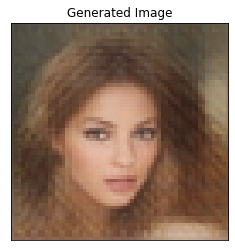

Epoch [166/500]...  ...183.903(s) feat_lo: 0.95092 - feat_med: 1.01444 - feat_hi: 0.99478 - KL: 49.99779
Epoch [167/500]...  ...183.872(s) feat_lo: 0.95052 - feat_med: 1.01402 - feat_hi: 0.99438 - KL: 50.00293
Epoch [168/500]...  ...183.868(s) feat_lo: 0.95027 - feat_med: 1.01386 - feat_hi: 0.99428 - KL: 49.99689
Epoch [169/500]...  ...183.936(s) feat_lo: 0.95047 - feat_med: 1.01398 - feat_hi: 0.99425 - KL: 50.00005
Epoch [170/500]...  ...183.913(s) feat_lo: 0.95028 - feat_med: 1.01390 - feat_hi: 0.99415 - KL: 50.00337
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


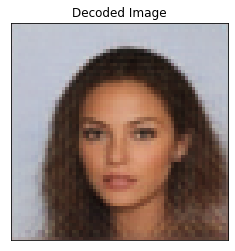

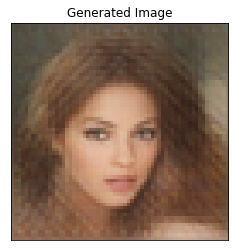

Epoch [171/500]...  ...183.922(s) feat_lo: 0.95027 - feat_med: 1.01375 - feat_hi: 0.99393 - KL: 49.99670
Epoch [172/500]...  ...183.791(s) feat_lo: 0.95009 - feat_med: 1.01359 - feat_hi: 0.99385 - KL: 49.99979
Epoch [173/500]...  ...183.731(s) feat_lo: 0.95012 - feat_med: 1.01362 - feat_hi: 0.99395 - KL: 50.00413
Epoch [174/500]...  ...183.927(s) feat_lo: 0.94998 - feat_med: 1.01345 - feat_hi: 0.99371 - KL: 49.99823
Epoch [175/500]...  ...183.871(s) feat_lo: 0.94969 - feat_med: 1.01317 - feat_hi: 0.99354 - KL: 50.00087
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


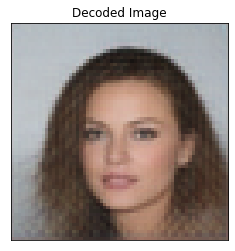

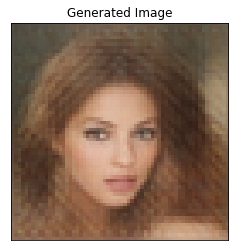

Epoch [176/500]...  ...184.006(s) feat_lo: 0.94957 - feat_med: 1.01307 - feat_hi: 0.99345 - KL: 49.99459
Epoch [177/500]...  ...184.019(s) feat_lo: 0.94936 - feat_med: 1.01285 - feat_hi: 0.99331 - KL: 50.00373
Epoch [178/500]...  ...183.996(s) feat_lo: 0.94934 - feat_med: 1.01290 - feat_hi: 0.99336 - KL: 49.99853
Epoch [179/500]...  ...183.906(s) feat_lo: 0.94942 - feat_med: 1.01284 - feat_hi: 0.99322 - KL: 49.99967
Epoch [180/500]...  ...184.081(s) feat_lo: 0.94938 - feat_med: 1.01285 - feat_hi: 0.99331 - KL: 50.00032
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


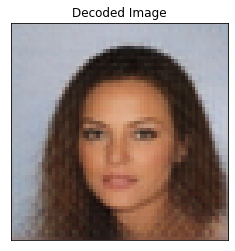

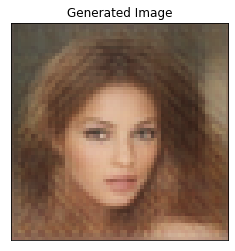

Epoch [181/500]...  ...183.946(s) feat_lo: 0.94907 - feat_med: 1.01258 - feat_hi: 0.99302 - KL: 50.00113
Epoch [182/500]...  ...183.901(s) feat_lo: 0.94901 - feat_med: 1.01248 - feat_hi: 0.99302 - KL: 49.99994
Epoch [183/500]...  ...183.943(s) feat_lo: 0.94881 - feat_med: 1.01231 - feat_hi: 0.99279 - KL: 50.00352
Epoch [184/500]...  ...183.907(s) feat_lo: 0.94875 - feat_med: 1.01240 - feat_hi: 0.99299 - KL: 49.99714
Epoch [185/500]...  ...183.945(s) feat_lo: 0.94857 - feat_med: 1.01209 - feat_hi: 0.99246 - KL: 49.99721
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


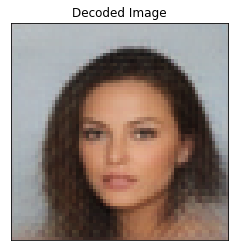

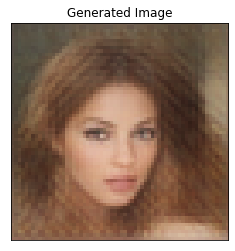

Epoch [186/500]...  ...183.933(s) feat_lo: 0.94857 - feat_med: 1.01210 - feat_hi: 0.99255 - KL: 50.00227
Epoch [187/500]...  ...183.950(s) feat_lo: 0.94835 - feat_med: 1.01192 - feat_hi: 0.99239 - KL: 49.99943
Epoch [188/500]...  ...184.001(s) feat_lo: 0.94864 - feat_med: 1.01217 - feat_hi: 0.99263 - KL: 50.00116
Epoch [189/500]...  ...183.756(s) feat_lo: 0.94817 - feat_med: 1.01166 - feat_hi: 0.99208 - KL: 50.00257
Epoch [190/500]...  ...183.823(s) feat_lo: 0.94821 - feat_med: 1.01170 - feat_hi: 0.99232 - KL: 49.99539
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


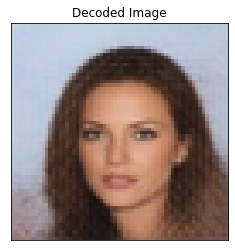

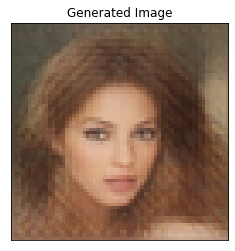

Epoch [191/500]...  ...183.920(s) feat_lo: 0.94816 - feat_med: 1.01158 - feat_hi: 0.99201 - KL: 50.00104
Epoch [192/500]...  ...183.886(s) feat_lo: 0.94799 - feat_med: 1.01157 - feat_hi: 0.99221 - KL: 50.00179
Epoch [193/500]...  ...183.874(s) feat_lo: 0.94808 - feat_med: 1.01156 - feat_hi: 0.99223 - KL: 49.99894
Epoch [194/500]...  ...183.783(s) feat_lo: 0.94777 - feat_med: 1.01118 - feat_hi: 0.99169 - KL: 50.00167
Epoch [195/500]...  ...183.906(s) feat_lo: 0.94758 - feat_med: 1.01119 - feat_hi: 0.99163 - KL: 49.99836
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


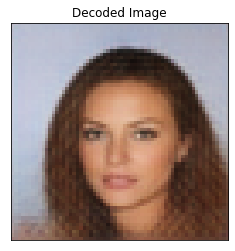

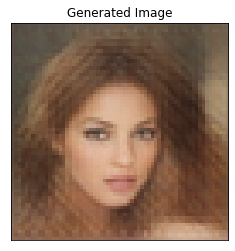

Epoch [196/500]...  ...183.846(s) feat_lo: 0.94758 - feat_med: 1.01100 - feat_hi: 0.99150 - KL: 49.99885
Epoch [197/500]...  ...183.923(s) feat_lo: 0.94762 - feat_med: 1.01118 - feat_hi: 0.99178 - KL: 49.99909
Epoch [198/500]...  ...183.898(s) feat_lo: 0.94749 - feat_med: 1.01089 - feat_hi: 0.99140 - KL: 50.00421
Epoch [199/500]...  ...183.864(s) feat_lo: 0.94755 - feat_med: 1.01107 - feat_hi: 0.99169 - KL: 50.00115
Epoch [200/500]...  ...183.788(s) feat_lo: 0.94721 - feat_med: 1.01072 - feat_hi: 0.99122 - KL: 49.99583
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


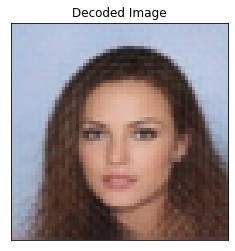

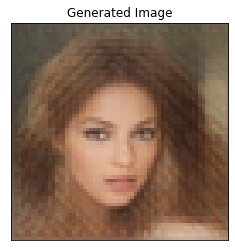

checkpointing at epoch: 200
Epoch [201/500]...  ...183.656(s) feat_lo: 0.94721 - feat_med: 1.01074 - feat_hi: 0.99122 - KL: 50.00037
Epoch [202/500]...  ...183.630(s) feat_lo: 0.94696 - feat_med: 1.01053 - feat_hi: 0.99100 - KL: 49.99921
Epoch [203/500]...  ...183.659(s) feat_lo: 0.94721 - feat_med: 1.01063 - feat_hi: 0.99121 - KL: 50.00130
Epoch [204/500]...  ...183.851(s) feat_lo: 0.94706 - feat_med: 1.01059 - feat_hi: 0.99123 - KL: 50.00264
Epoch [205/500]...  ...183.722(s) feat_lo: 0.94674 - feat_med: 1.01020 - feat_hi: 0.99080 - KL: 49.99782
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


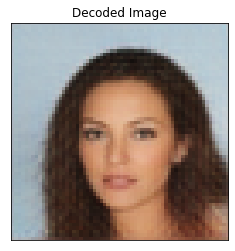

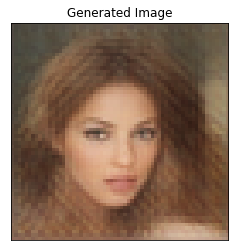

Epoch [206/500]...  ...183.752(s) feat_lo: 0.94681 - feat_med: 1.01034 - feat_hi: 0.99093 - KL: 50.00439
Epoch [207/500]...  ...183.647(s) feat_lo: 0.94672 - feat_med: 1.01032 - feat_hi: 0.99101 - KL: 49.99472
Epoch [208/500]...  ...183.818(s) feat_lo: 0.94663 - feat_med: 1.01004 - feat_hi: 0.99058 - KL: 50.00223
Epoch [209/500]...  ...183.958(s) feat_lo: 0.94661 - feat_med: 1.01006 - feat_hi: 0.99065 - KL: 49.99919
Epoch [210/500]...  ...183.976(s) feat_lo: 0.94650 - feat_med: 1.01005 - feat_hi: 0.99076 - KL: 49.99983
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


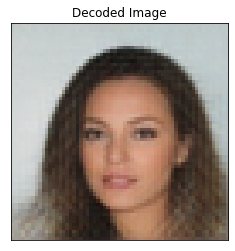

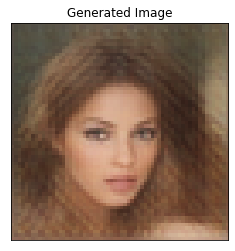

Epoch [211/500]...  ...184.044(s) feat_lo: 0.94645 - feat_med: 1.00984 - feat_hi: 0.99041 - KL: 49.99964
Epoch [212/500]...  ...184.040(s) feat_lo: 0.94622 - feat_med: 1.00964 - feat_hi: 0.99029 - KL: 49.99875
Epoch [213/500]...  ...184.039(s) feat_lo: 0.94637 - feat_med: 1.00971 - feat_hi: 0.99031 - KL: 50.00159
Epoch [214/500]...  ...183.970(s) feat_lo: 0.94584 - feat_med: 1.00937 - feat_hi: 0.98994 - KL: 49.99545
Epoch [215/500]...  ...184.152(s) feat_lo: 0.94592 - feat_med: 1.00936 - feat_hi: 0.99001 - KL: 50.00446
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


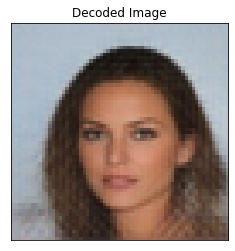

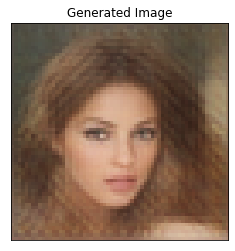

Epoch [216/500]...  ...184.003(s) feat_lo: 0.94590 - feat_med: 1.00936 - feat_hi: 0.99004 - KL: 49.99848
Epoch [217/500]...  ...184.008(s) feat_lo: 0.94569 - feat_med: 1.00910 - feat_hi: 0.98983 - KL: 50.00058
Epoch [218/500]...  ...184.004(s) feat_lo: 0.94598 - feat_med: 1.00939 - feat_hi: 0.99004 - KL: 49.99793
Epoch [219/500]...  ...183.747(s) feat_lo: 0.94563 - feat_med: 1.00914 - feat_hi: 0.98981 - KL: 50.00404
Epoch [220/500]...  ...183.796(s) feat_lo: 0.94563 - feat_med: 1.00911 - feat_hi: 0.98982 - KL: 49.99914
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


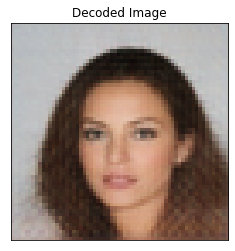

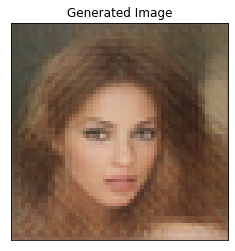

Epoch [221/500]...  ...183.949(s) feat_lo: 0.94553 - feat_med: 1.00901 - feat_hi: 0.98975 - KL: 49.99918
Epoch [222/500]...  ...183.693(s) feat_lo: 0.94546 - feat_med: 1.00884 - feat_hi: 0.98943 - KL: 49.99950
Epoch [223/500]...  ...183.894(s) feat_lo: 0.94558 - feat_med: 1.00897 - feat_hi: 0.98979 - KL: 50.00501
Epoch [224/500]...  ...183.983(s) feat_lo: 0.94534 - feat_med: 1.00880 - feat_hi: 0.98953 - KL: 49.99592
Epoch [225/500]...  ...184.139(s) feat_lo: 0.94521 - feat_med: 1.00865 - feat_hi: 0.98946 - KL: 49.99652
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


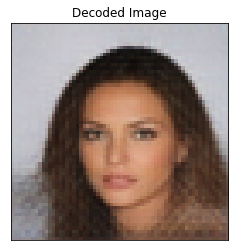

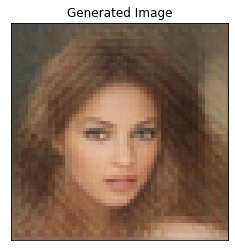

Epoch [226/500]...  ...183.933(s) feat_lo: 0.94519 - feat_med: 1.00864 - feat_hi: 0.98939 - KL: 50.00104
Epoch [227/500]...  ...184.024(s) feat_lo: 0.94499 - feat_med: 1.00843 - feat_hi: 0.98915 - KL: 50.00066
Epoch [228/500]...  ...183.961(s) feat_lo: 0.94510 - feat_med: 1.00860 - feat_hi: 0.98937 - KL: 50.00139
Epoch [229/500]...  ...183.961(s) feat_lo: 0.94513 - feat_med: 1.00870 - feat_hi: 0.98943 - KL: 49.99975
Epoch [230/500]...  ...183.949(s) feat_lo: 0.94497 - feat_med: 1.00832 - feat_hi: 0.98911 - KL: 49.99926
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


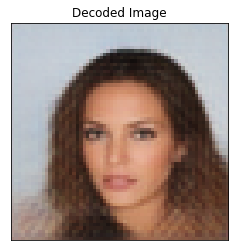

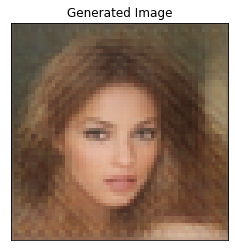

Epoch [231/500]...  ...184.008(s) feat_lo: 0.94473 - feat_med: 1.00818 - feat_hi: 0.98887 - KL: 50.00064
Epoch [232/500]...  ...183.929(s) feat_lo: 0.94467 - feat_med: 1.00807 - feat_hi: 0.98872 - KL: 50.00215
Epoch [233/500]...  ...183.878(s) feat_lo: 0.94472 - feat_med: 1.00813 - feat_hi: 0.98884 - KL: 49.99801
Epoch [234/500]...  ...183.936(s) feat_lo: 0.94463 - feat_med: 1.00800 - feat_hi: 0.98861 - KL: 50.00028
Epoch [235/500]...  ...183.725(s) feat_lo: 0.94443 - feat_med: 1.00794 - feat_hi: 0.98875 - KL: 49.99872
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


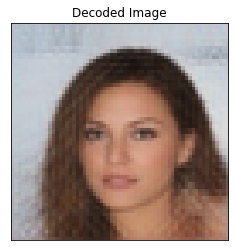

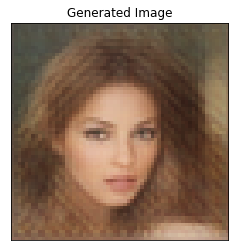

Epoch [236/500]...  ...183.802(s) feat_lo: 0.94450 - feat_med: 1.00794 - feat_hi: 0.98872 - KL: 50.00221
Epoch [237/500]...  ...183.830(s) feat_lo: 0.94443 - feat_med: 1.00787 - feat_hi: 0.98860 - KL: 50.00014
Epoch [238/500]...  ...183.866(s) feat_lo: 0.94424 - feat_med: 1.00770 - feat_hi: 0.98853 - KL: 49.99631
Epoch [239/500]...  ...183.914(s) feat_lo: 0.94414 - feat_med: 1.00753 - feat_hi: 0.98821 - KL: 50.00328
Epoch [240/500]...  ...183.940(s) feat_lo: 0.94436 - feat_med: 1.00758 - feat_hi: 0.98844 - KL: 49.99721
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


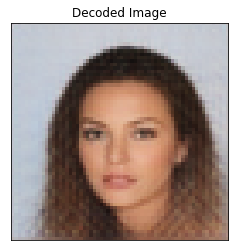

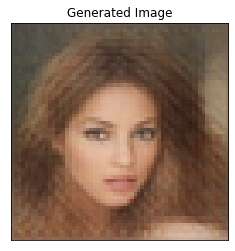

Epoch [241/500]...  ...183.901(s) feat_lo: 0.94405 - feat_med: 1.00743 - feat_hi: 0.98827 - KL: 50.00345
Epoch [242/500]...  ...183.848(s) feat_lo: 0.94411 - feat_med: 1.00749 - feat_hi: 0.98825 - KL: 49.99758
Epoch [243/500]...  ...183.930(s) feat_lo: 0.94377 - feat_med: 1.00720 - feat_hi: 0.98800 - KL: 49.99890
Epoch [244/500]...  ...184.380(s) feat_lo: 0.94375 - feat_med: 1.00707 - feat_hi: 0.98785 - KL: 50.00164
Epoch [245/500]...  ...184.189(s) feat_lo: 0.94382 - feat_med: 1.00730 - feat_hi: 0.98808 - KL: 50.00136
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


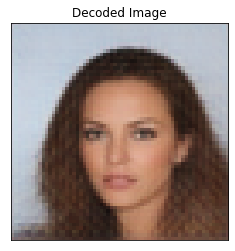

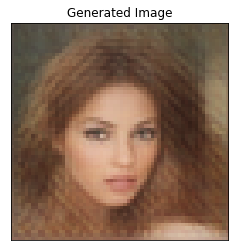

Epoch [246/500]...  ...184.144(s) feat_lo: 0.94373 - feat_med: 1.00709 - feat_hi: 0.98781 - KL: 50.00047
Epoch [247/500]...  ...184.106(s) feat_lo: 0.94378 - feat_med: 1.00720 - feat_hi: 0.98802 - KL: 49.99797
Epoch [248/500]...  ...184.007(s) feat_lo: 0.94372 - feat_med: 1.00710 - feat_hi: 0.98787 - KL: 49.99989
Epoch [249/500]...  ...184.052(s) feat_lo: 0.94357 - feat_med: 1.00694 - feat_hi: 0.98770 - KL: 50.00224
Epoch [250/500]...  ...183.835(s) feat_lo: 0.94364 - feat_med: 1.00706 - feat_hi: 0.98783 - KL: 49.99726
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


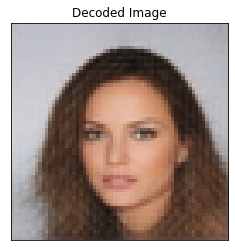

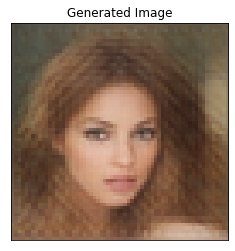

checkpointing at epoch: 250
Epoch [251/500]...  ...184.079(s) feat_lo: 0.94305 - feat_med: 1.00646 - feat_hi: 0.98719 - KL: 50.00296
Epoch [252/500]...  ...183.886(s) feat_lo: 0.94322 - feat_med: 1.00650 - feat_hi: 0.98730 - KL: 49.99910
Epoch [253/500]...  ...183.932(s) feat_lo: 0.94312 - feat_med: 1.00664 - feat_hi: 0.98747 - KL: 49.99672
Epoch [254/500]...  ...183.925(s) feat_lo: 0.94296 - feat_med: 1.00642 - feat_hi: 0.98718 - KL: 50.00186
Epoch [255/500]...  ...184.035(s) feat_lo: 0.94312 - feat_med: 1.00659 - feat_hi: 0.98755 - KL: 50.00414
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


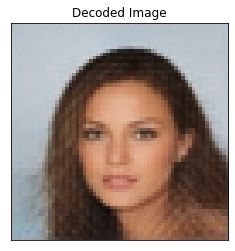

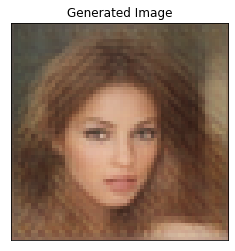

Epoch [256/500]...  ...184.176(s) feat_lo: 0.94334 - feat_med: 1.00678 - feat_hi: 0.98759 - KL: 49.99321
Epoch [257/500]...  ...184.169(s) feat_lo: 0.94298 - feat_med: 1.00646 - feat_hi: 0.98733 - KL: 50.00422
Epoch [258/500]...  ...184.181(s) feat_lo: 0.94294 - feat_med: 1.00628 - feat_hi: 0.98709 - KL: 50.00138
Epoch [259/500]...  ...184.152(s) feat_lo: 0.94292 - feat_med: 1.00633 - feat_hi: 0.98721 - KL: 49.99801
Epoch [260/500]...  ...184.108(s) feat_lo: 0.94269 - feat_med: 1.00603 - feat_hi: 0.98684 - KL: 49.99777
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


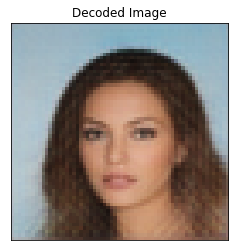

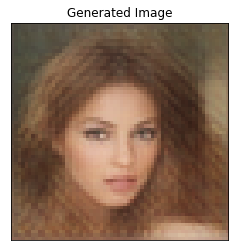

Epoch [261/500]...  ...183.985(s) feat_lo: 0.94270 - feat_med: 1.00612 - feat_hi: 0.98703 - KL: 50.00160
Epoch [262/500]...  ...184.046(s) feat_lo: 0.94252 - feat_med: 1.00583 - feat_hi: 0.98679 - KL: 50.00061
Epoch [263/500]...  ...184.160(s) feat_lo: 0.94269 - feat_med: 1.00608 - feat_hi: 0.98701 - KL: 50.00049
Epoch [264/500]...  ...184.111(s) feat_lo: 0.94247 - feat_med: 1.00578 - feat_hi: 0.98667 - KL: 49.99725
Epoch [265/500]...  ...184.129(s) feat_lo: 0.94258 - feat_med: 1.00592 - feat_hi: 0.98678 - KL: 50.00444
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


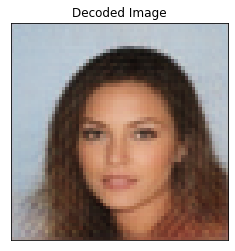

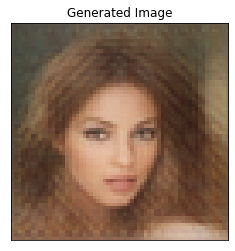

Epoch [266/500]...  ...184.117(s) feat_lo: 0.94237 - feat_med: 1.00575 - feat_hi: 0.98664 - KL: 49.99875
Epoch [267/500]...  ...184.167(s) feat_lo: 0.94223 - feat_med: 1.00555 - feat_hi: 0.98648 - KL: 50.00053
Epoch [268/500]...  ...184.155(s) feat_lo: 0.94235 - feat_med: 1.00580 - feat_hi: 0.98665 - KL: 49.99608
Epoch [269/500]...  ...184.146(s) feat_lo: 0.94242 - feat_med: 1.00577 - feat_hi: 0.98675 - KL: 50.00036
Epoch [270/500]...  ...184.158(s) feat_lo: 0.94221 - feat_med: 1.00558 - feat_hi: 0.98645 - KL: 50.00317
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


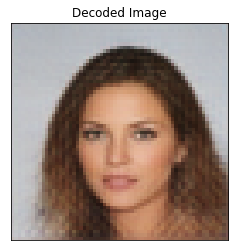

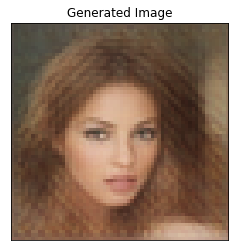

Epoch [271/500]...  ...184.173(s) feat_lo: 0.94223 - feat_med: 1.00573 - feat_hi: 0.98665 - KL: 49.99840
Epoch [272/500]...  ...184.153(s) feat_lo: 0.94212 - feat_med: 1.00551 - feat_hi: 0.98648 - KL: 49.99999
Epoch [273/500]...  ...184.168(s) feat_lo: 0.94223 - feat_med: 1.00550 - feat_hi: 0.98636 - KL: 49.99864
Epoch [274/500]...  ...184.169(s) feat_lo: 0.94187 - feat_med: 1.00526 - feat_hi: 0.98611 - KL: 50.00060
Epoch [275/500]...  ...184.118(s) feat_lo: 0.94207 - feat_med: 1.00540 - feat_hi: 0.98622 - KL: 49.99899
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


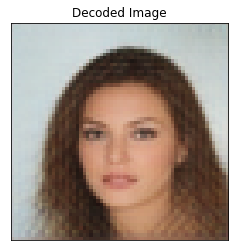

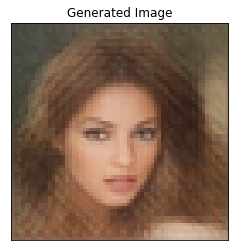

Epoch [276/500]...  ...184.194(s) feat_lo: 0.94183 - feat_med: 1.00528 - feat_hi: 0.98631 - KL: 49.99839
Epoch [277/500]...  ...184.109(s) feat_lo: 0.94173 - feat_med: 1.00501 - feat_hi: 0.98583 - KL: 50.00668
Epoch [278/500]...  ...184.117(s) feat_lo: 0.94163 - feat_med: 1.00500 - feat_hi: 0.98600 - KL: 49.99620
Epoch [279/500]...  ...184.138(s) feat_lo: 0.94162 - feat_med: 1.00494 - feat_hi: 0.98589 - KL: 50.00124
Epoch [280/500]...  ...184.152(s) feat_lo: 0.94177 - feat_med: 1.00517 - feat_hi: 0.98613 - KL: 49.99549
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


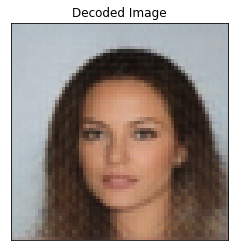

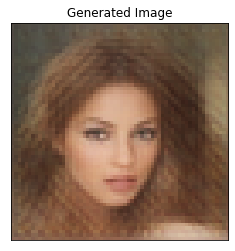

Epoch [281/500]...  ...184.180(s) feat_lo: 0.94158 - feat_med: 1.00491 - feat_hi: 0.98591 - KL: 50.00713
Epoch [282/500]...  ...184.128(s) feat_lo: 0.94149 - feat_med: 1.00490 - feat_hi: 0.98580 - KL: 49.99532
Epoch [283/500]...  ...184.100(s) feat_lo: 0.94119 - feat_med: 1.00449 - feat_hi: 0.98525 - KL: 49.99936
Epoch [284/500]...  ...184.143(s) feat_lo: 0.94125 - feat_med: 1.00456 - feat_hi: 0.98567 - KL: 50.00189
Epoch [285/500]...  ...184.130(s) feat_lo: 0.94141 - feat_med: 1.00482 - feat_hi: 0.98583 - KL: 50.00060
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


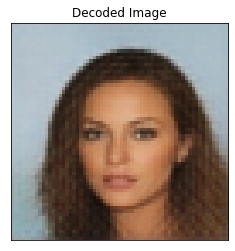

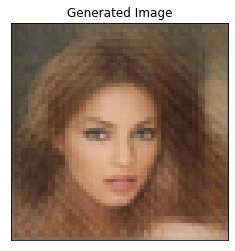

Epoch [286/500]...  ...184.125(s) feat_lo: 0.94135 - feat_med: 1.00480 - feat_hi: 0.98569 - KL: 49.99766
Epoch [287/500]...  ...184.004(s) feat_lo: 0.94123 - feat_med: 1.00455 - feat_hi: 0.98556 - KL: 50.00342
Epoch [288/500]...  ...184.163(s) feat_lo: 0.94104 - feat_med: 1.00437 - feat_hi: 0.98544 - KL: 50.00150
Epoch [289/500]...  ...184.290(s) feat_lo: 0.94115 - feat_med: 1.00443 - feat_hi: 0.98544 - KL: 49.99681
Epoch [290/500]...  ...184.304(s) feat_lo: 0.94096 - feat_med: 1.00432 - feat_hi: 0.98529 - KL: 50.00197
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


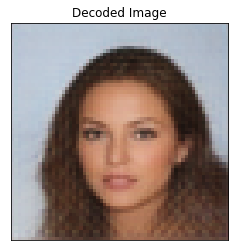

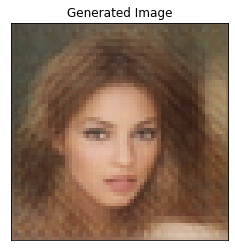

Epoch [291/500]...  ...184.319(s) feat_lo: 0.94112 - feat_med: 1.00452 - feat_hi: 0.98546 - KL: 49.99819
Epoch [292/500]...  ...184.268(s) feat_lo: 0.94082 - feat_med: 1.00415 - feat_hi: 0.98530 - KL: 49.99950
Epoch [293/500]...  ...184.075(s) feat_lo: 0.94081 - feat_med: 1.00411 - feat_hi: 0.98511 - KL: 50.00175
Epoch [294/500]...  ...184.260(s) feat_lo: 0.94076 - feat_med: 1.00409 - feat_hi: 0.98500 - KL: 49.99754
Epoch [295/500]...  ...184.289(s) feat_lo: 0.94089 - feat_med: 1.00417 - feat_hi: 0.98516 - KL: 50.00303
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


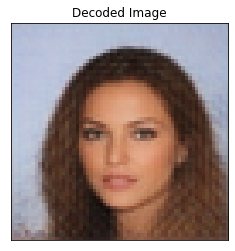

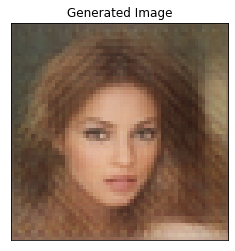

Epoch [296/500]...  ...184.232(s) feat_lo: 0.94089 - feat_med: 1.00428 - feat_hi: 0.98524 - KL: 50.00115
Epoch [297/500]...  ...185.575(s) feat_lo: 0.94060 - feat_med: 1.00398 - feat_hi: 0.98495 - KL: 49.99738
Epoch [298/500]...  ...184.789(s) feat_lo: 0.94055 - feat_med: 1.00392 - feat_hi: 0.98503 - KL: 50.00040
Epoch [299/500]...  ...184.443(s) feat_lo: 0.94052 - feat_med: 1.00384 - feat_hi: 0.98481 - KL: 50.00017
Epoch [300/500]...  ...184.296(s) feat_lo: 0.94054 - feat_med: 1.00388 - feat_hi: 0.98489 - KL: 50.00074
Arched_Eyebrows 1
Attractive 1
Brown_Hair 1
Heavy_Makeup 1
Mouth_Slightly_Open 1
No_Beard 1
Pointy_Nose 1
Wavy_Hair 1
Wearing_Lipstick 1
Young 1


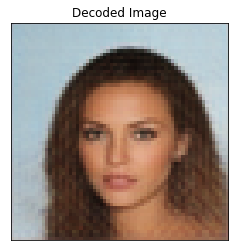

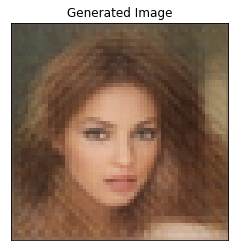

checkpointing at epoch: 300
Epoch [301/500]...  ...184.781(s) feat_lo: 0.94052 - feat_med: 1.00377 - feat_hi: 0.98485 - KL: 49.99707
Epoch [302/500]...  

KeyboardInterrupt: 

In [138]:
import time
from pathlib import Path

epochs = 500
batch_size = 64
checkpoint_every_n_epochs = 50
figure_every_n_epochs = 5

# control vae params
k_p = 0.01 # proportional constant
k_i = 0.0001 # integral constant
i_t = 0 # discrete integrator
beta_max = 1.0 
beta_min = 0.0
desired_kl = 50
beta = 0.0


model_type = f'controlled-kl-dfc-cvae-{desired_kl}kl'


#create base dir
base_model_path = Path(f'./models/{model_type}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    training_imgs = training_data[0]
    training_attribs = training_data[1]
    training_attribs  = np.cast['float32'](training_attribs)

    num_batches = len(training_imgs) // batch_size

    # losses
    rl_lo_loss_list = [] 
    rl_med_loss_list = [] 
    rl_hi_loss_list = [] 
    kl_loss_list = []

    
    test_attribute = training_data[1][0]
    test_img = training_data[0][0]
    mu, sigma = 0, 1 #mean and standard deviation
    s = np.random.normal(mu, sigma, latent_dim)
    

    

    


    for epoch in range(1,epochs+1):
        start = time.time()
        print(f'Epoch [{epoch}/{epochs}]...'.ljust(20), end = '')


        
        idxs = np.arange(0,len(training_imgs))
        np.random.shuffle(idxs)
        
        img_input = training_imgs[idxs]
        attribute_input = training_attribs[idxs]


        rl_lo_loss_total = 0
        rl_med_loss_total = 0
        rl_hi_loss_total = 0
        kl_loss_total = 0

         

        
        
        for index in range(num_batches):
            img_batch = img_input[index*batch_size: batch_size*(index+1)]
            attribute_batch = attribute_input[index*batch_size: batch_size*(index+1)] 
            

            rl_lo_loss, rl_med_loss, rl_hi_loss, kl_loss = train_step(img_batch , attribute_batch, tf.constant(beta, dtype=tf.float32))
            rl_lo_loss_total += K.get_value(rl_lo_loss)
            rl_med_loss_total += K.get_value(rl_med_loss)
            rl_hi_loss_total += K.get_value(rl_hi_loss)
            kl_loss_total += K.get_value(kl_loss)


            # control vae 
            error_t = desired_kl - K.get_value(kl_loss)
            p_t = k_p / (1+np.exp(error_t))

            if beta_min <= beta and beta <= beta_max:
                i_t = i_t - k_i*error_t

            beta = p_t + i_t + beta_min

            beta = min(beta, beta_max)
            beta = max(beta, beta_min)


        
        
       
        rl_lo_mean = rl_lo_loss_total/num_batches
        rl_med_mean = rl_med_loss_total/num_batches
        rl_hi_mean = rl_hi_loss_total/num_batches
        kl_loss_mean = kl_loss_total/num_batches
        
        rl_lo_loss_list.append(rl_lo_mean) 
        rl_med_loss_list.append(rl_med_mean) 
        rl_hi_loss_list.append(rl_hi_mean)
        kl_loss_list.append(kl_loss_mean)



        print(f'...{time.time()-start:.3f}(s) '  , end='')
       
        
        print(f'feat_lo: {rl_lo_mean:.5f} - ', end='') 
        print(f'feat_med: {rl_med_mean:.5f} - ', end='') 
        print(f'feat_hi: {rl_hi_mean:.5f} - ', end='')         
        print(f'KL: {kl_loss_mean:.5f}')

        

        if epoch % figure_every_n_epochs == 0:
            encode_to_attribs(test_attribute)
            _, _, z = encoder.predict([test_img.reshape(1,width,height,3), test_attribute.reshape(1,-1)])
            dec_img = unnormalize_tanh( decoder.predict([z, test_attribute.reshape(1,n_conds)])[0])
            plt.imshow(dec_img)
            plt.title("Decoded Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'decoded-{epoch}.png')
            plt.show()
            
            gen_img = unnormalize_tanh( decoder.predict([np.array([s]),np.array([test_attribute])])[0])        
            plt.imshow(gen_img)
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            decoder.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-decoder-weights.h5').as_posix())
            decoder.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-decoder.h5').as_posix())
            encoder.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-encoder-weights.h5').as_posix())
            encoder.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-encoder.h5').as_posix())
            

In [78]:
def normalize(loss_list):
    loss_list = np.array(loss_list)
    return (loss_list - loss_list.min()) / (loss_list.max() - loss_list.min())

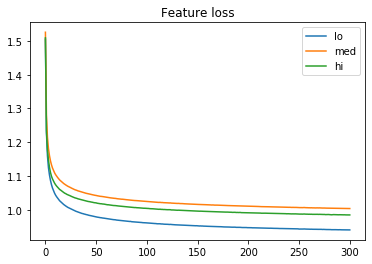

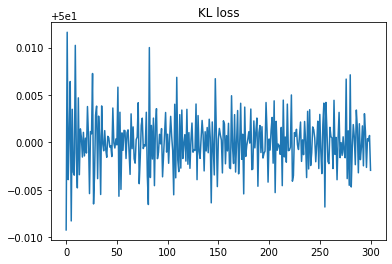

In [143]:


plt.plot(rl_lo_loss_list, label="lo")
plt.plot(rl_med_loss_list, label="med")
plt.plot(rl_hi_loss_list, label="hi")
plt.title("Feature loss")
plt.legend()
plt.savefig(figure_model_path / 'feature_loss.png')
plt.show()
 
plt.plot(kl_loss_list)
plt.title("KL loss")
plt.savefig(figure_model_path / 'encoder_loss.png')
plt.show()


In [537]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label
from ipywidgets import Layout, Button, Box

In [439]:
def get_attribs():
    attribs = '''5oClockShadow, ArchedEyebrows, Attractive, BagsUnderEyes, Bald, Bangs, BigLips, BigNose, BlackHair, BlondeHair, Blurry, BrownHair, BushyEyebrows, Chubby, DoubleChin, Glasses, Goatee, GrayHair, HeavyMakeup, HighCheekbones, Male, MouthSlightlyOpen, Mustache, NarrowEyes, NoBeard, OvalFace, PaleSkin, PointyNose, RecedingHairline, RosyCheeks, Sideburns, Smiling, StraightHair, WavyHair, WearingEarrings, WearingHat, WearingLipstick, WearingNecklace, WearingNecktie, Young'''
    attribs = attribs.split(',')
    attribs = [attrib.strip() for attrib in attribs]
    return attribs

In [440]:
attrib_dict = {attrib:i for i,attrib in enumerate(get_attribs())}

In [417]:
def generate(decoder, noise, attribute, name="untitled", show_attributes=False, save_fig=False):
    gen_img = unnormalize_tanh( decoder.predict([np.array([noise]),np.array([attribute])])[0])        
    plt.imshow(gen_img)

    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if show_attributes:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        txt = plt.text(65, 0, attribs_to_str(attribute), fontsize=10, bbox=props, va="top")
    plt.tight_layout()
    if save_fig:
        val_model_path = base_model_path / 'validation'
        val_model_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(val_model_path / f'{name}.png',bbox_extra_artists=(txt,),bbox_inches = "tight")
    
    plt.show()

In [506]:
[i for i in range(-5,6)]

[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

In [628]:
sliders = []
items = []

items_layout = Layout( width='40%',display='flex')
labels_layout = Layout( display='flex', width='10%')

box_layout = Layout(display='flex',
                    flex_flow='column wrap',
                    align_items='center',
                    width='100%',
                    height='100%')
inner_box_layout = Layout(display='flex',
                    flex_flow='row nowrap',
                    align_items='center',
                    width='100%')

for attrib in get_attribs():
    slider = widgets.FloatSlider(
        min=-5,
        max=5,
        layout=items_layout,
        step=0.5,
        value=-1    )
#     slider = widgets.ToggleButtons(
#         options=[i for i in range(-5,6)],
#         value=-1, # Defaults to 'pineapple'
#     #    layout={'width': 'max-content'}, # If the items' names are long
#         layout=items_layout,
#         disabled=False)
    items.append(Box(children=[Label(attrib, layout=labels_layout),slider], layout=inner_box_layout))
    
#     slider = widgets.ToggleButtons(
#         options=[i for i in range(-5,6)],
#        value=-1, # Defaults to 'pineapple'
#     #    layout={'width': 'max-content'}, # If the items' names are long
#         layout=items_layout,
#         disabled=False
    sliders.append(slider)

    
box = Box(children=items, layout=box_layout)

# for label, slider in zip(labels,sliders):
# #     display(label)
# #     display(slider)

display(box)

Box(children=(Box(children=(Label(value='5oClockShadow', layout=Layout(display='flex', width='10%')), FloatSli…

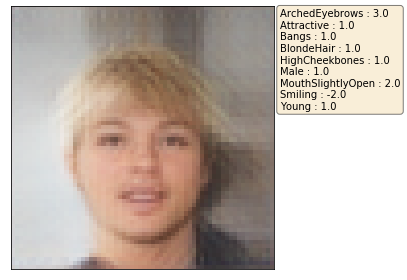

In [696]:
conditions = np.array([slider.value for slider in sliders])
# conditions = test_attribute
# conditions = training_attribs[100]
# encode_to_attribs(conditions)
mu, sigma = 0, 1 #mean and standard deviation
noise = np.random.normal(mu, sigma,200)
generate(decoder,noise,conditions, show_attributes=True)


In [485]:
validation_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(64, 64),
    subset='validation',
    shuffle=True,
    batch_size=128,
    class_mode='raw')

Found 40519 validated image filenames.


In [476]:
val_data = validation_generator.next()

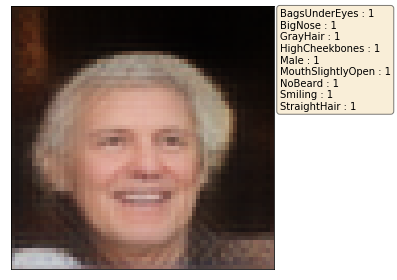

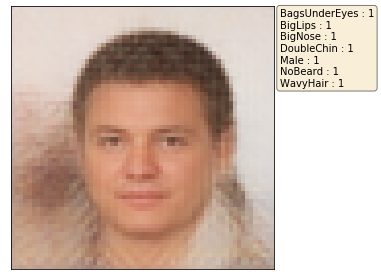

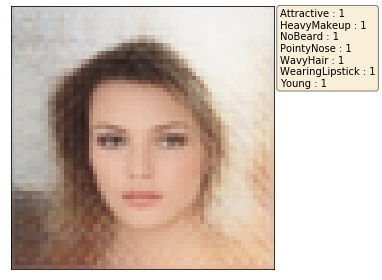

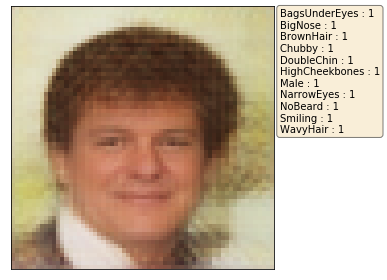

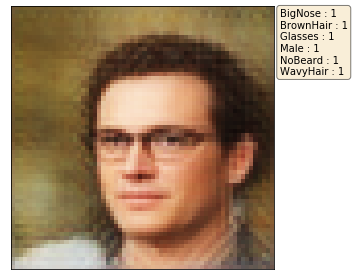

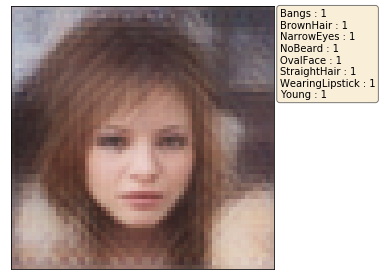

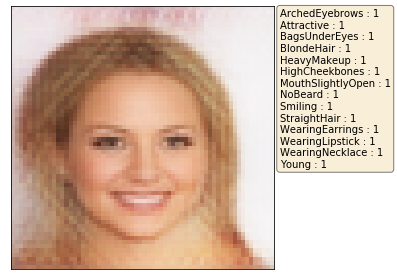

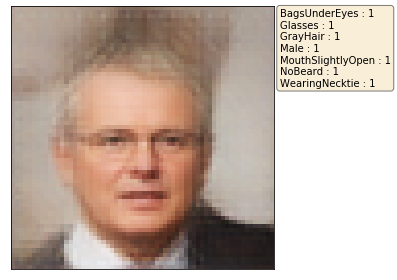

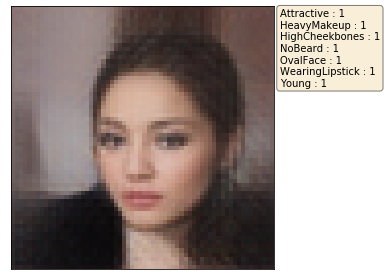

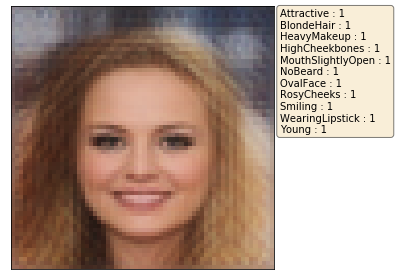

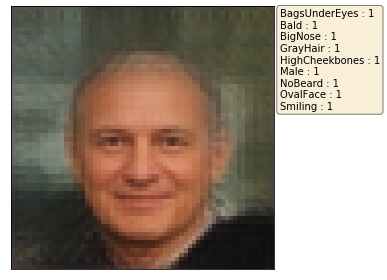

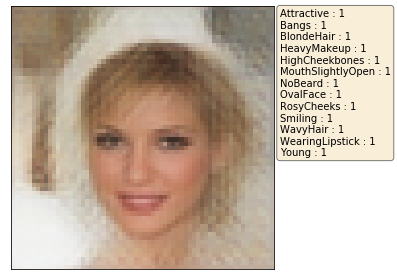

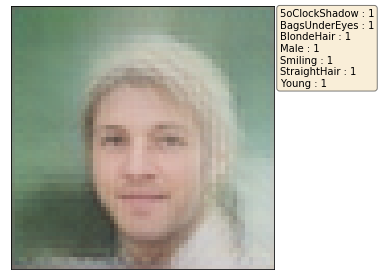

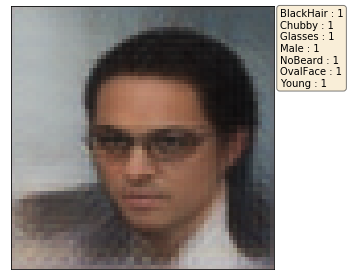

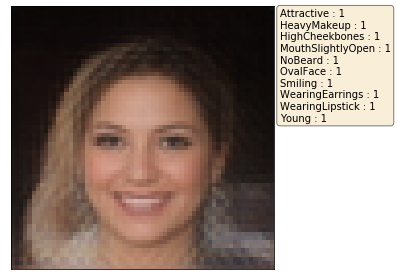

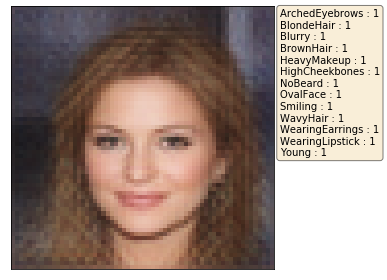

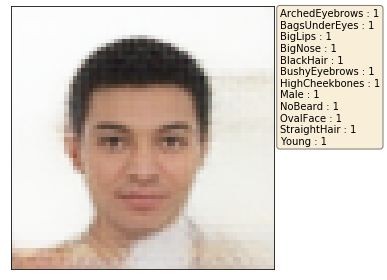

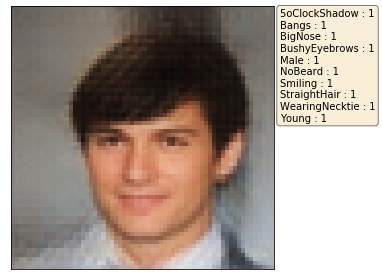

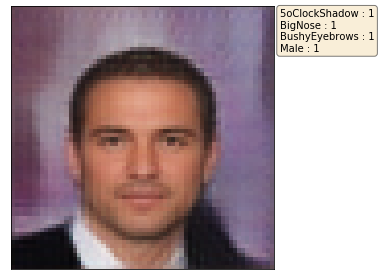

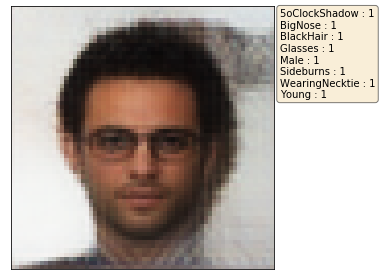

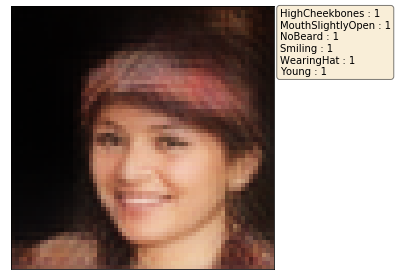

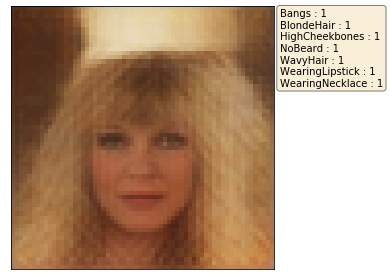

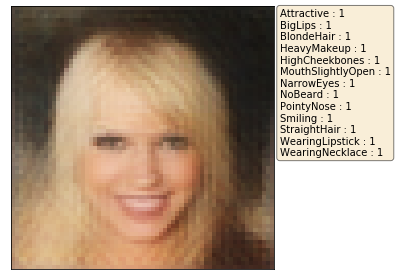

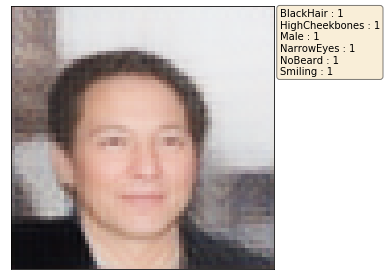

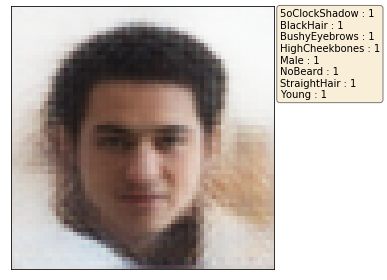

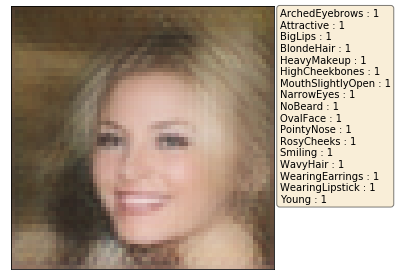

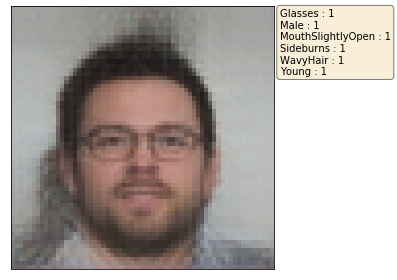

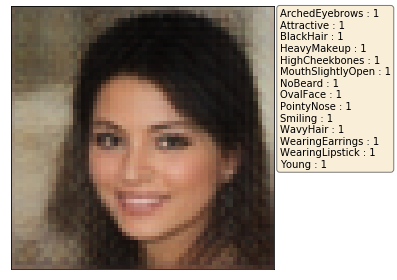

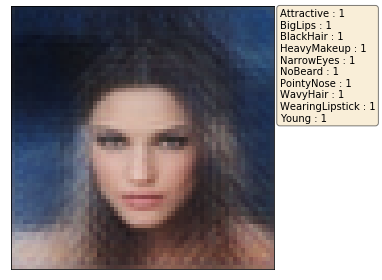

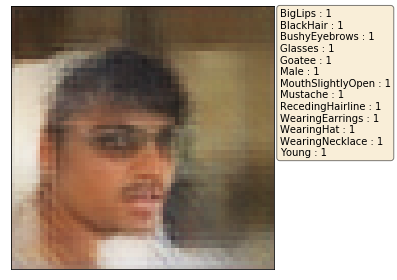

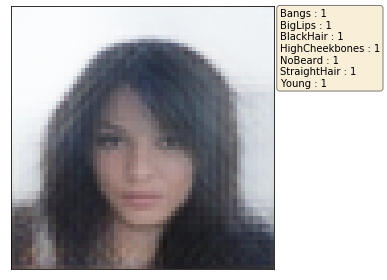

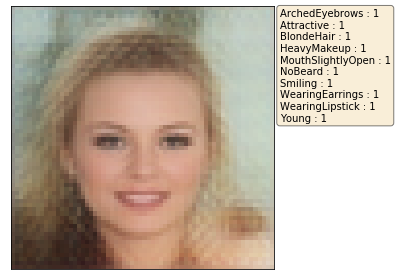

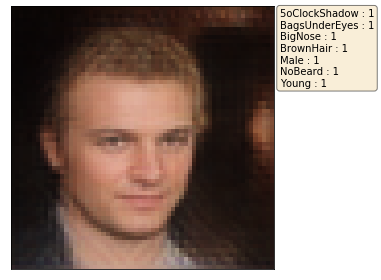

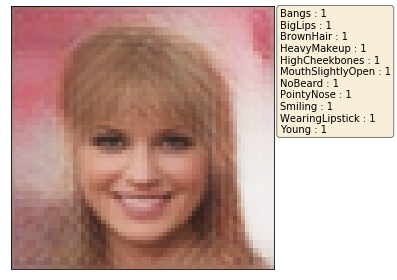

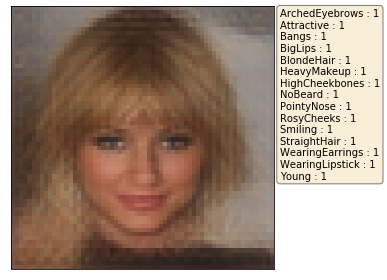

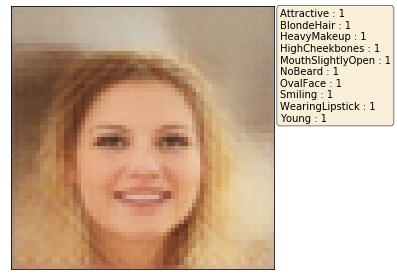

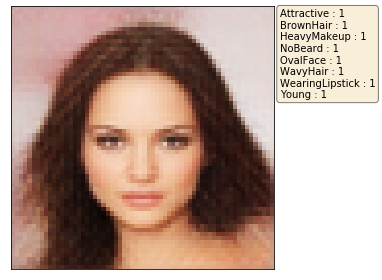

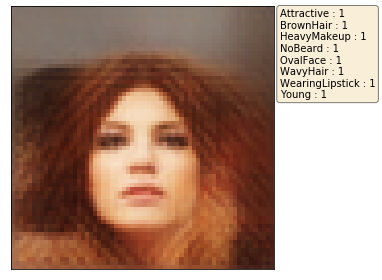

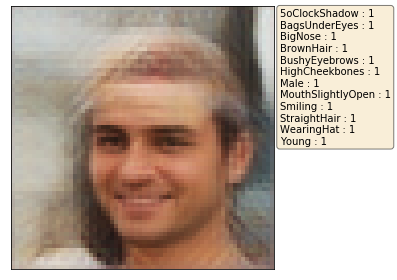

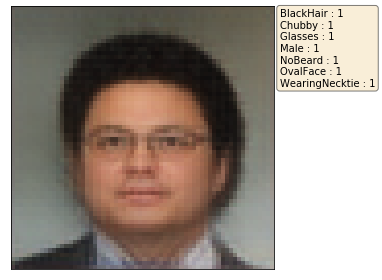

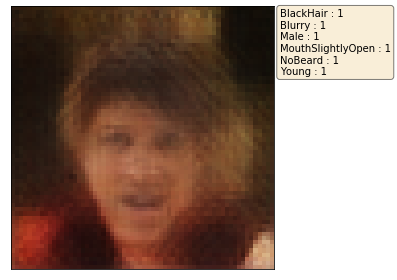

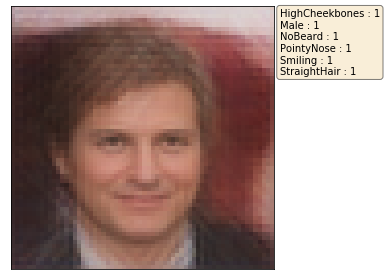

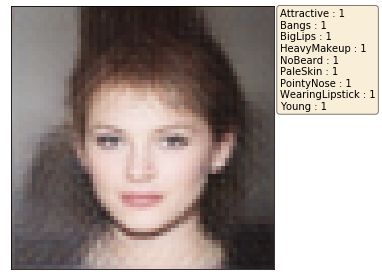

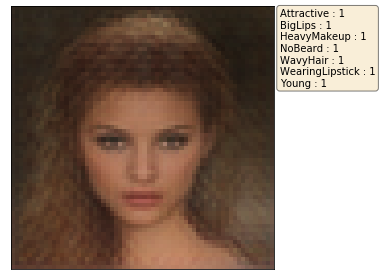

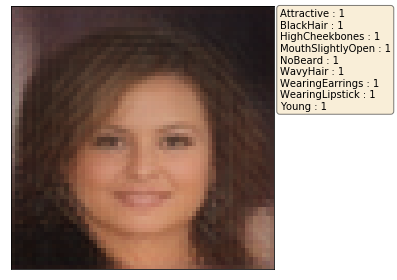

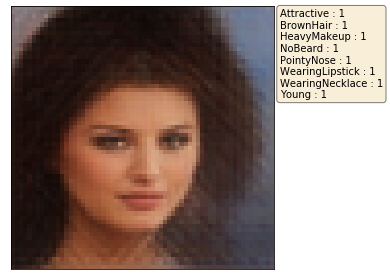

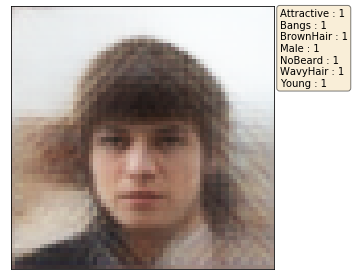

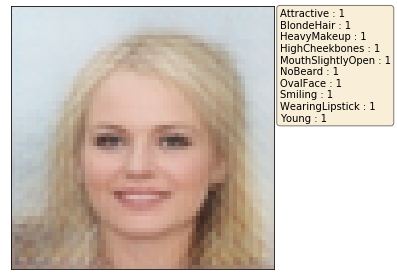

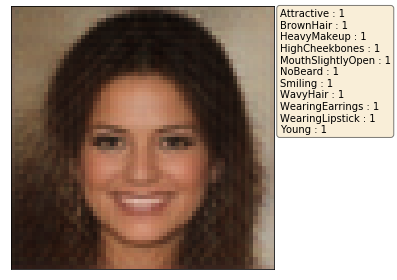

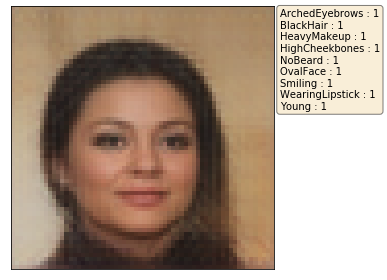

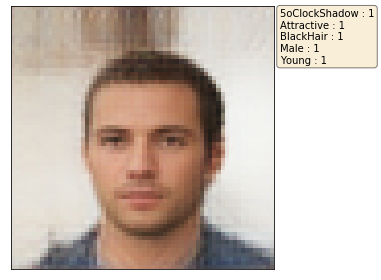

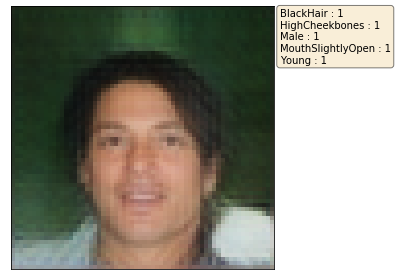

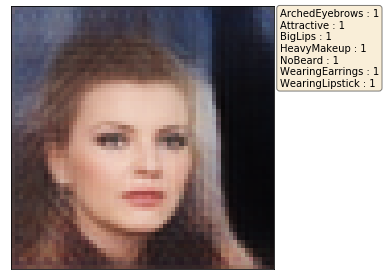

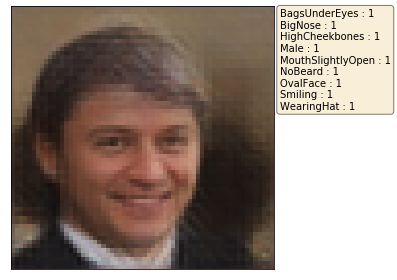

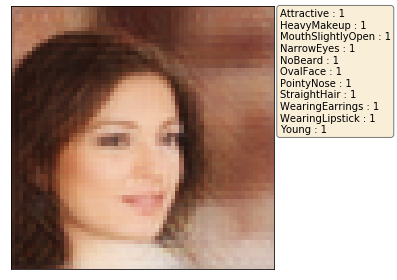

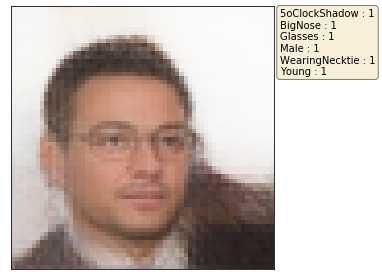

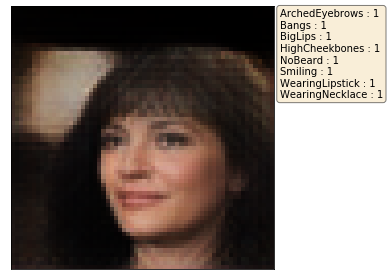

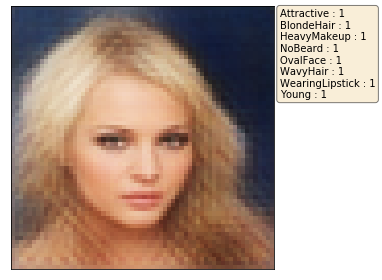

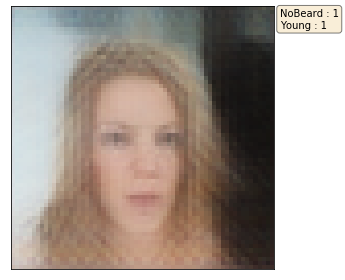

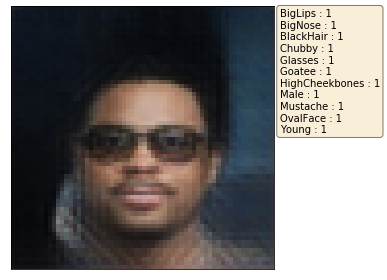

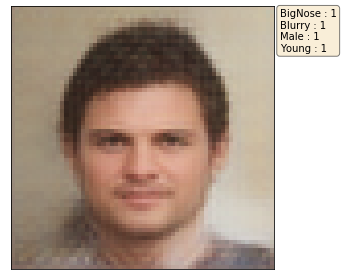

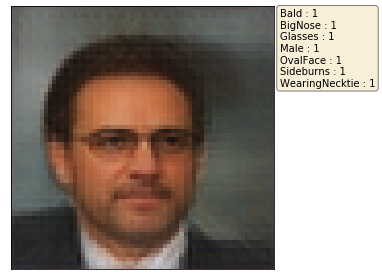

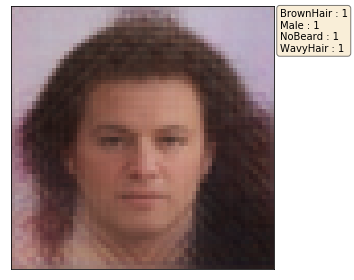

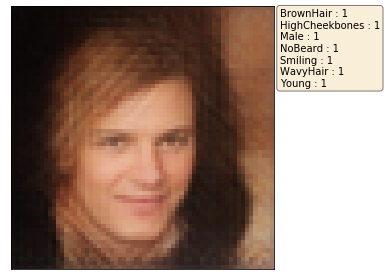

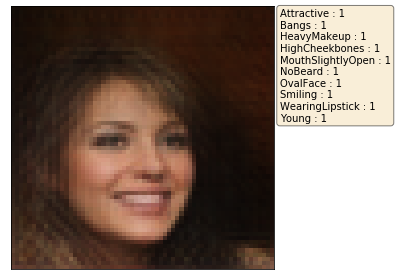

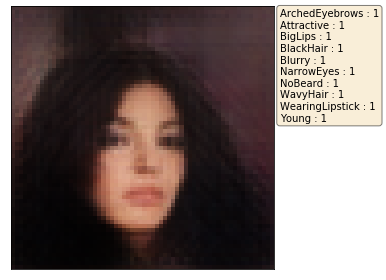

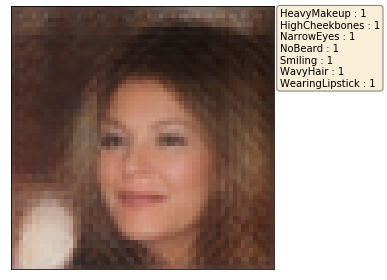

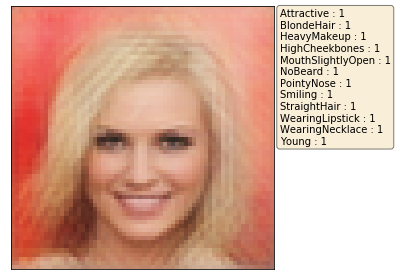

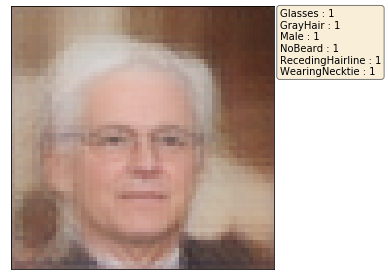

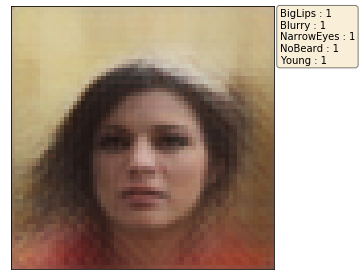

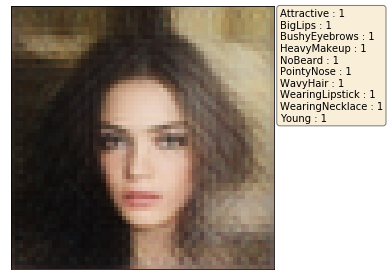

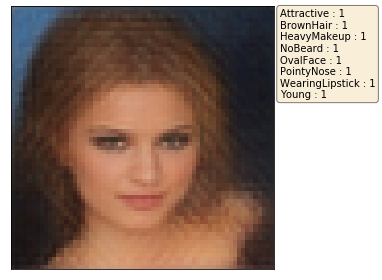

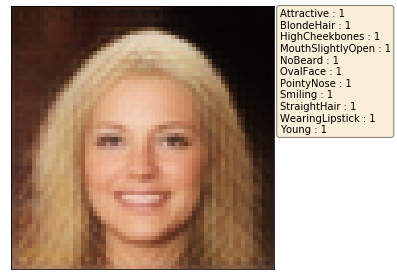

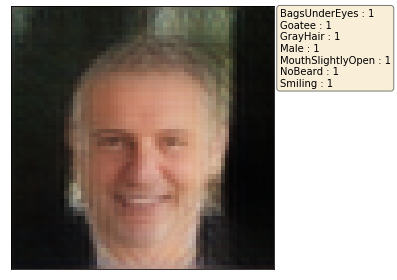

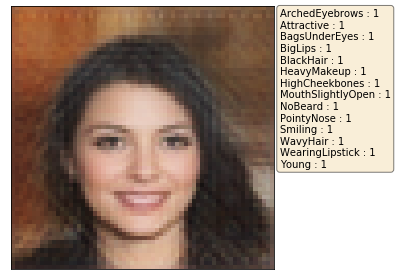

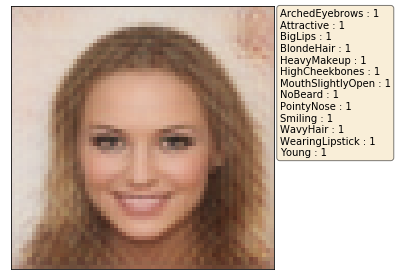

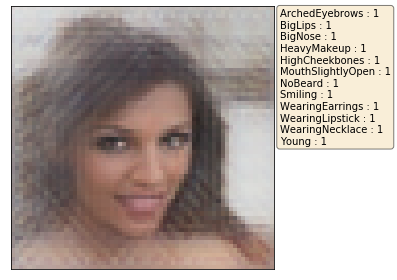

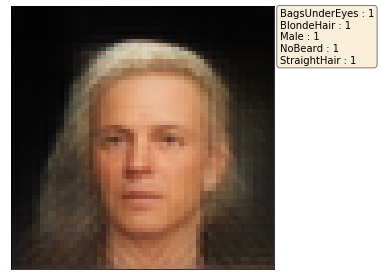

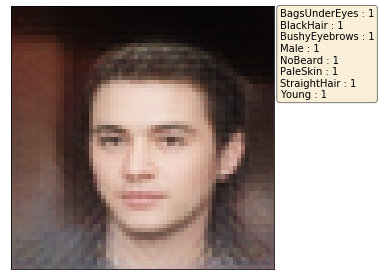

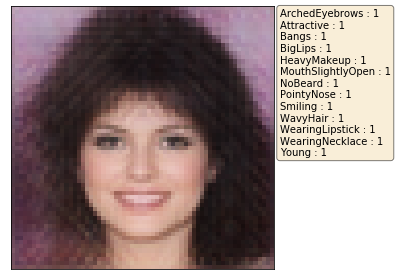

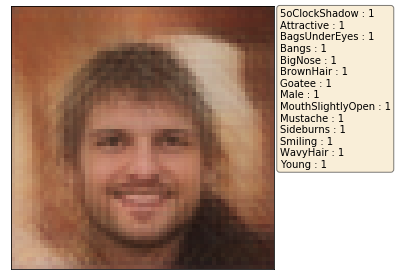

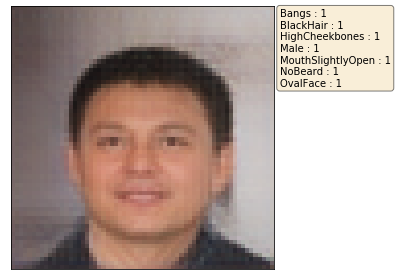

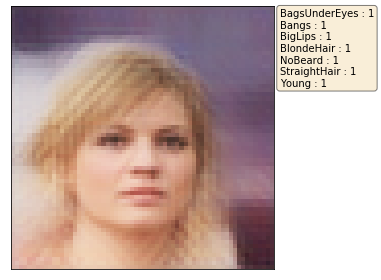

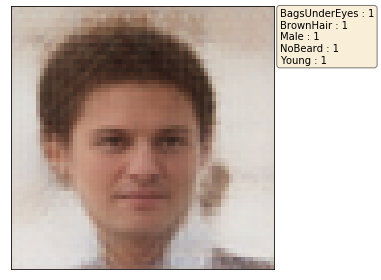

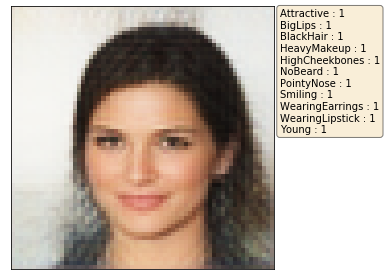

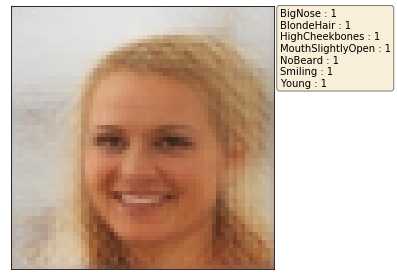

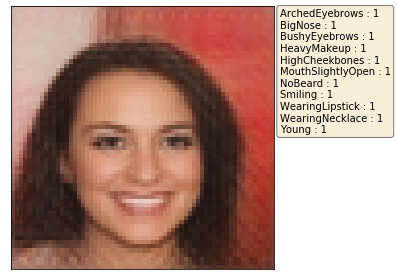

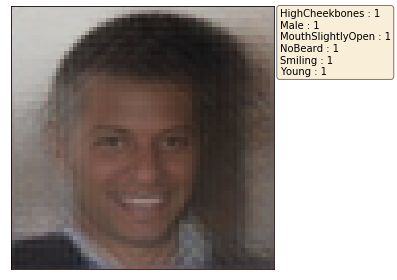

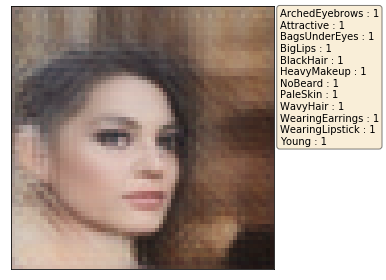

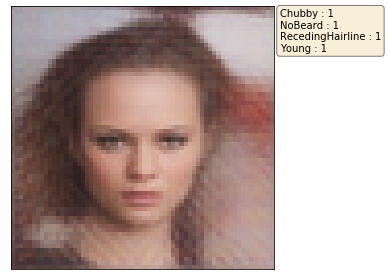

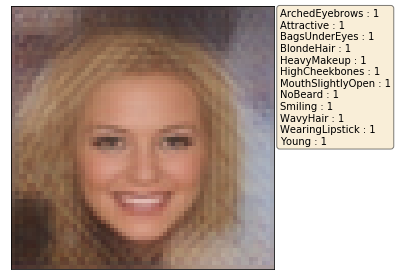

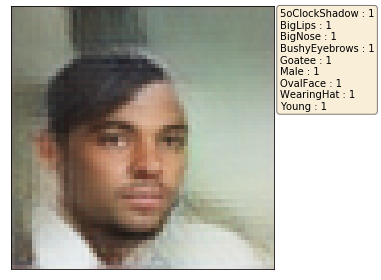

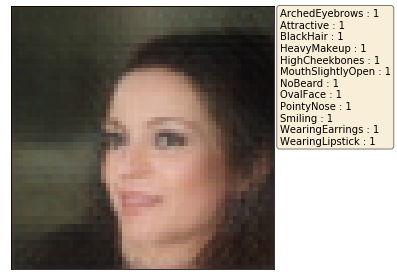

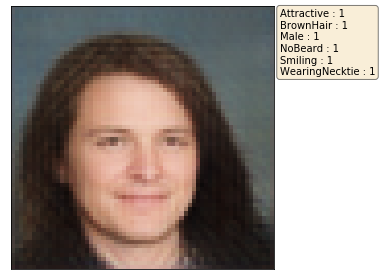

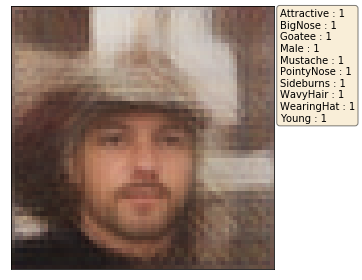

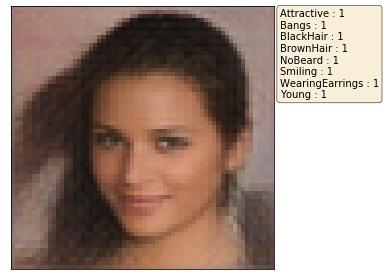

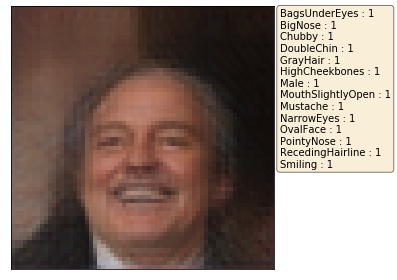

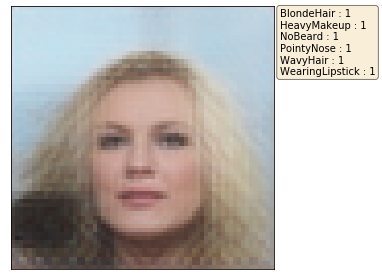

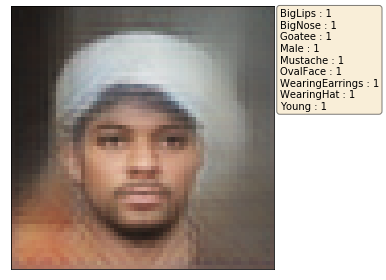

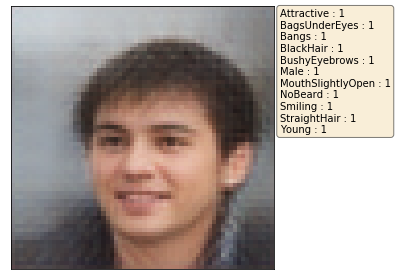

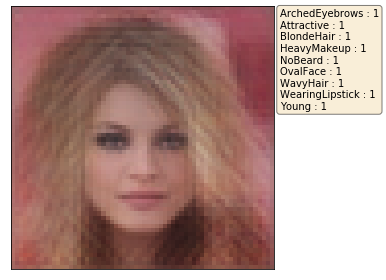

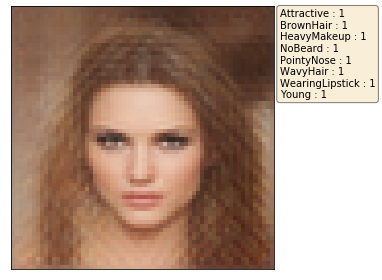

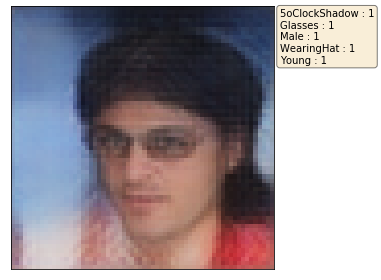

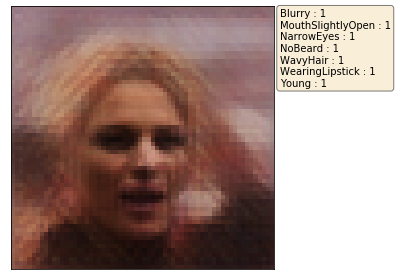

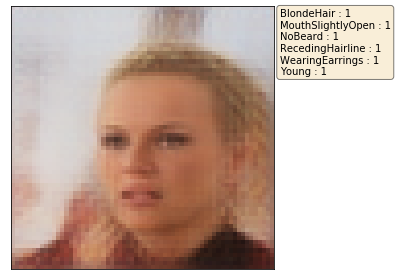

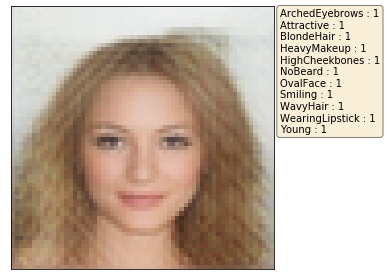

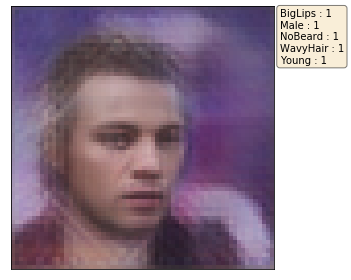

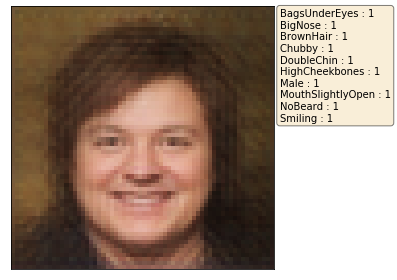

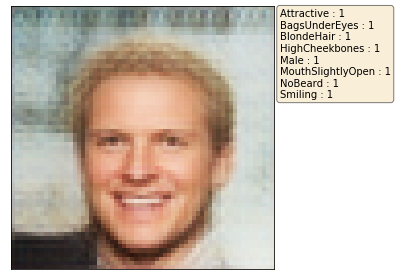

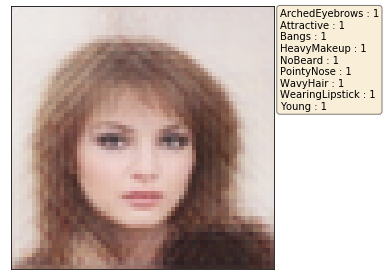

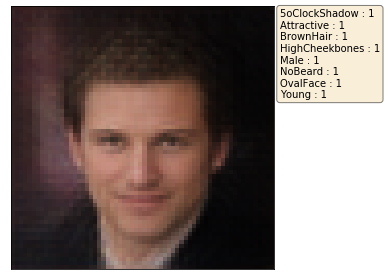

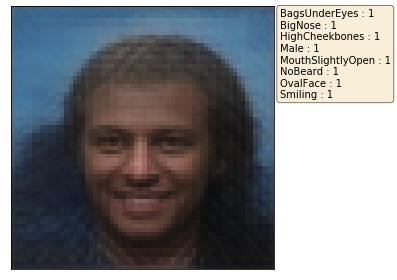

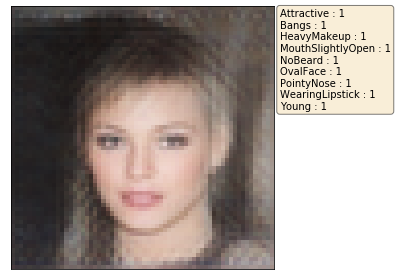

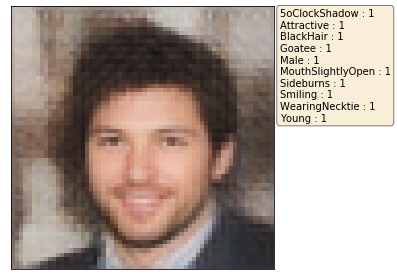

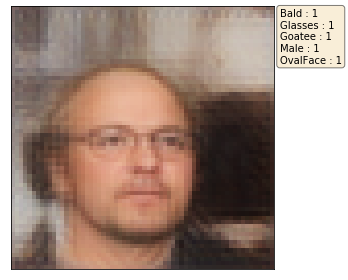

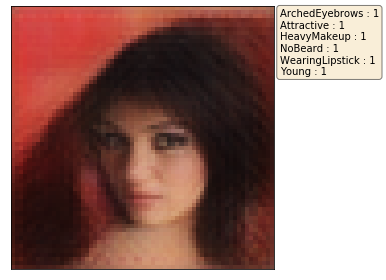

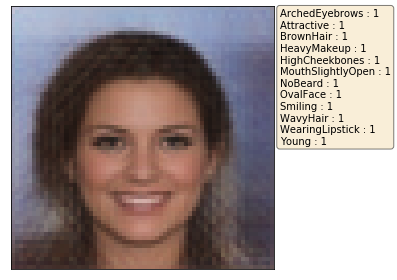

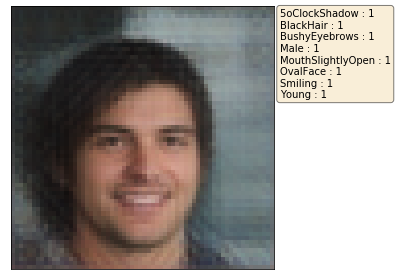

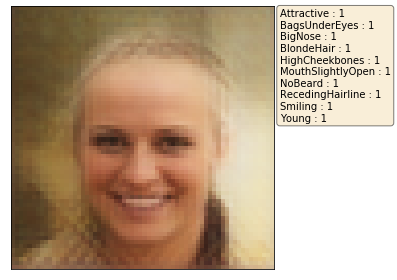

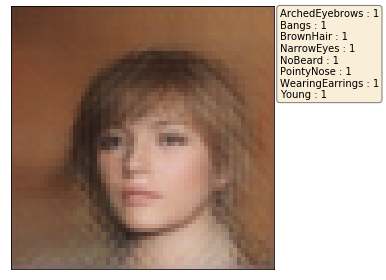

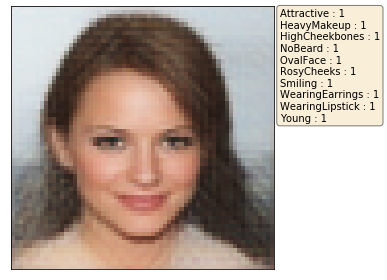

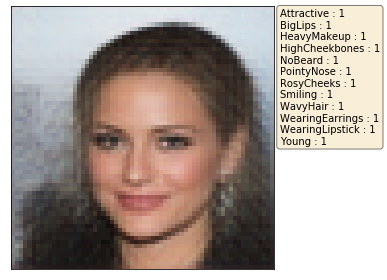

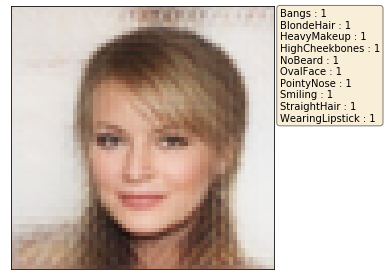

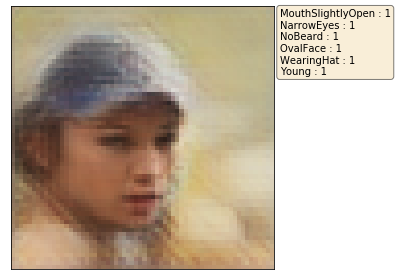

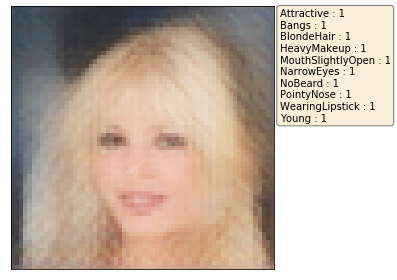

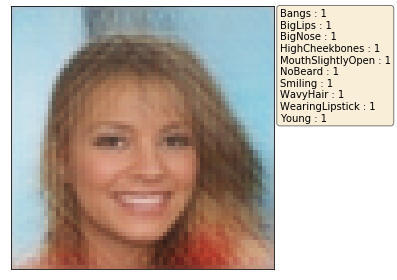

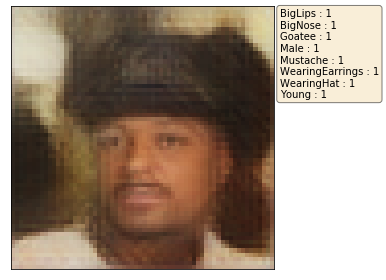

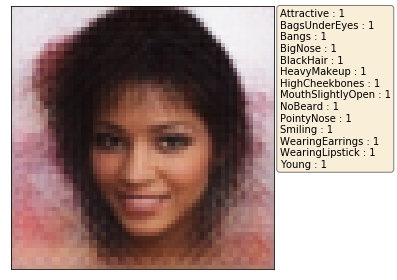

In [478]:
for i, attribute in enumerate(val_data[1]):
    noise = np.random.normal(mu, sigma,200)
    generate(decoder,noise,attribute,name=f'val-{i}', show_attributes=True, save_fig=True)